# Vorhersage von Trainerentlassungen mittels logistischer Regression

## Zielsetzung
Ziel dieses Notebooks ist es, Trainerentlassungen (Binary Target: coach_dismissal) anhand leistungsbezogener Metriken (RP, LRC, ERC) und des Saisonzeitpunkts (matchday) zu modellieren.  
Neben einem Baseline-Modell werden Feature-Kombinationen, alternative Zieldefinitionen (Next-3/Next-5) und zusätzliche Features (z.B. Formtrend, Losing Streak) getestet.

## Forschungsfrage
In welchem Ausmaß können performancebezogene Kennzahlen und zeitliche Variablen Trainerentlassungen vorhersagen und welche Features sind statistisch am relevantesten?


## Setup: Import der benötigten Bibliotheken

Zur Reproduzierbarkeit und Transparenz wird zu Beginn des Notebooks der vollständige Paketumfang importiert. Die Bibliotheken decken die folgenden Funktionsbereiche ab:

1. **Datenaufbereitung und numerische Verarbeitung**
   - `pandas` und `numpy` dienen zur Datenmanipulation (Tabellenoperationen, Aggregationen) sowie zur effizienten numerischen Verarbeitung.

2. **Visualisierung**
   - `matplotlib.pyplot` und `seaborn` werden für explorative Visualisierungen (z.B. Verteilungen, Korrelationen, Modellkurven) genutzt.

3. **Statistische Modellierung (Interpretierbarkeit)**
   - `statsmodels.api` wird verwendet, um logistische Regressionen als statistische Modelle zu schätzen und inferenzstatistische Kennzahlen (z.B. p-Werte, Konfidenzintervalle) auszuwerten.

4. **Maschinelles Lernen (Prognosefokus)**
   - Mit scikit-learn werden standardisierte Pipelines aufgebaut, die Vorverarbeitung und Modellschätzung kombinieren:
     - Fehlwertbehandlung über `SimpleImputer`
     - Skalierung über `StandardScaler`
     - Modelle: `LogisticRegression` und `LogisticRegressionCV` (inkl. regulärer CV-Logik)
   - Zur Modellbewertung werden u.a. ROC/AUC (`roc_curve`, `roc_auc_score`) sowie weitere Klassifikationsmetriken (Accuracy, Confusion Matrix, Precision-Recall über `average_precision_score`) genutzt.

5. **Alternatives Modell (nichtlinear, benchmarkfähig)**
   - `XGBClassifier` (XGBoost) wird als leistungsfähiges, nichtlineares Vergleichsmodell importiert, um die Baseline (logistische Regression) gegen ein komplexeres Modell benchmarken zu können.


In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score


## Datenimport und Vorauswahl relevanter Variablen

In diesem Schritt wird der Datensatz eingelesen und auf eine vordefinierte Auswahl relevanter Variablen reduziert.  
Ziel ist es, nur solche Spalten zu laden, die für die spätere Analyse und Modellierung der Trainerentlassungen notwendig sind, um Speicherverbrauch zu reduzieren und die Übersichtlichkeit zu erhöhen.


In [2]:
filtered_cols = [
    "league",
    "year",
    "team",
    "matchday",
    "date",
    "result",
    "xpts_diff",
    "rp",
    "lrc",
    "erc",
    "coach_dismissal",
    "table_position",
    "winless_streak",
]

df = pd.read_csv("coach_data_new.csv", usecols=filtered_cols)
df.head()

,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
0,Bundesliga,2014,Augsburg,1,2014-08-23 14:30:00,l,-26.470588,-1.002589,-1.002589,0,1,0.3100,17
1,Bundesliga,2014,Augsburg,2,2014-08-29 19:30:00,l,-32.352941,-1.877378,-1.494423,0,2,0.5541,18
2,Bundesliga,2014,Augsburg,3,2014-09-14 14:30:00,w,2.941176,-0.047717,0.906056,0,0,-1.5167,12
3,Bundesliga,2014,Augsburg,4,2014-09-20 14:30:00,w,20.588235,1.215819,1.823510,0,0,-1.0268,9
4,Bundesliga,2014,Augsburg,5,2014-09-24 19:00:00,l,8.823529,0.456069,0.367242,0,1,0.4800,11


## Explorative Analyse der Performance-Metriken (RP, LRC, ERC)

In diesem Schritt werden die drei von den Sportlern berechneten Performance-Metriken RP, LRC und ERC näher untersucht.  
Ziel ist es, sowohl ihre statistischen Eigenschaften als auch ihre gegenseitigen Zusammenhänge zu analysieren, um mögliche Redundanzen oder Skalierungsprobleme frühzeitig zu erkennen.

### Korrelationen
Es werden Pearson-Korrelationen zwischen den Metriken berechnet. Dabei zeigt sich:
- Eine **starke positive Korrelation zwischen LRC und ERC (r ≈ 0.82)**, was zwecks der ähnliche Konstruktion der Metriken zu erwarten war, was in späteren Modellen zu Multikollinearität führen kann.
- RP weist hingegen nur eine moderate Korrelation mit LRC (r ≈ 0.41) und nahezu keine Korrelation mit ERC (r ≈ 0.08) auf.

### Deskriptive Statistik
Zusätzlich werden zentrale Lage- und Streuungsmaße berechnet:
- Die Mittelwerte aller drei Metriken liegen nahe bei null, was eine Normalisierung zeigt.
- Gleichzeitig weisen insbesondere RP und LRC sehr große Wertebereiche auf, was auf starke Gewichtungen einzelner Spiele schließen lässt.
- die Nachbildung der einzelnen Paramter ist aufgrund der Datenlage nicht möglich, teils scheint es als würden einzelne Werte wie das Normalisierungsgewicht oder der harmonische Gewichtungsparamter willkürlich bestimmt worden sein ohne weiteren Hintergrund


In [3]:
cols = ["rp", "lrc", "erc"]
display(df[cols].corr())

overview = df[cols].describe()
overview

,rp,lrc,erc
rp,1.000000,0.407529,0.082410
lrc,0.407529,1.000000,0.819301
erc,0.082410,0.819301,1.000000


,rp,lrc,erc
count,40232.000000,40232.000000,40231.000000
mean,0.143238,-0.091186,-0.033437
std,26.909215,7.894676,6.281846
min,-100.000000,-1225.000000,-1225.000000
25%,-17.647059,-2.964839,-1.136955
50%,0.000000,-0.049073,-0.072598
75%,14.705882,2.844843,1.085879
max,111.764706,27.943167,5.359940


## Identifikation extremer Minimalwerte der Performance-Metriken

Zur Plausibilitätsprüfung der Performance-Metriken werden für RP, LRC und ERC die jeweiligen Minimalwerte identifiziert und die zugehörigen Beobachtungen angezeigt.  
Ziel ist es, mögliche Ausreißer oder systematische Grenzwerte in den Metriken zu erkennen.

In [4]:
for col in cols:
    min_val = overview.loc["min", col]
    min_rows = df[df[col] == min_val]
    print(f"\nSpalte: {col}, min = {min_val}")
    display(min_rows)



Spalte: rp, min = -100.0


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
15703,Ligue 1,2014,Monaco,2,2014-08-17 20:00:00,l,-100.0,-3.635679,-2.782607,0,2,0.0196,19
15706,Ligue 1,2014,Monaco,5,2014-09-12 19:30:00,l,-100.0,-4.273639,-1.861137,0,2,0.7277,19



Spalte: lrc, min = -1225.0


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
28764,Premier League,2021,Burnley,1,2021-08-14 14:00:00,l,38.235294,-1225.0,-1225.0,0,1,1.4559,12



Spalte: erc, min = -1225.0


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
28764,Premier League,2021,Burnley,1,2021-08-14 14:00:00,l,38.235294,-1225.0,-1225.0,0,1,1.4559,12


## Analyse extremer Maximalwerte der Performance-Metriken

Analog zur Untersuchung der Minimalwerte werden für RP, LRC und ERC die jeweiligen Maximalwerte bestimmt und die zugehörigen Beobachtungen angezeigt.  
Ziel ist es, die Spannweite der Metriken vollständig zu erfassen und potenzielle Ausreißer zu identifizieren.


In [5]:
for col in cols:
    max_val = overview.loc["max", col]
    max_rows = df[df[col] == max_val]
    print(f"Spalte: {col}, max = {max_val}")
    display(max_rows)


Spalte: rp, max = 111.7647059


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
16082,Ligue 1,2015,Angers,1,2015-08-08 23:00:00,w,111.764706,2.119300,2.119300,0,0,-0.9673,1
20554,Ligue 1,2021,Clermont Foot,1,2021-08-08 13:00:00,w,111.764706,1.968577,1.968577,0,0,-201.0000,1


Spalte: lrc, max = 27.94316663


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
24316,Premier League,2015,Leicester,37,2016-05-07 20:30:00,w,85.294118,27.943167,1.906247,0,0,-0.1718,1


Spalte: erc, max = 5.359940234


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
9594,La Liga,2017,Levante,37,2018-05-13 19:45:00,w,23.529412,9.683514,5.35994,0,0,-0.6401,15


## Verteilungsanalyse der Performance-Metriken

Zur weiteren explorativen Analyse werden Histogramme der drei Performance-Metriken RP, LRC und ERC erstellt.  
Ziel ist es, Form, Streuung und Ausreißer der Verteilungen visuell zu untersuchen.

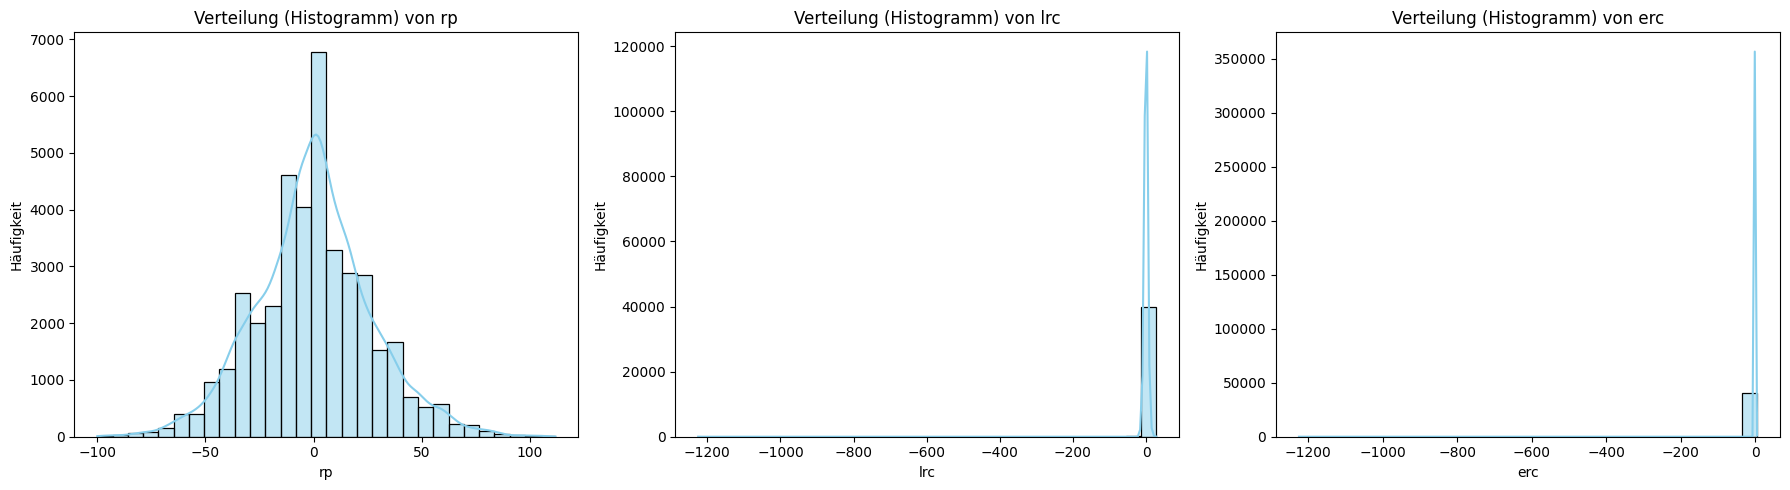

In [6]:
cols = ["rp", "lrc", "erc"]

plot_data = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

plt.figure(figsize=(18, 5))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(plot_data[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Verteilung (Histogramm) von {col}")
    plt.xlabel(col)
    plt.ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

## Scatterplot-Matrix der Performance-Metriken

Zur Ergänzung der Korrelationsanalyse wird eine Scatterplot-Matrix für die drei Performance-Metriken RP, LRC und ERC erstellt.  
Diese Darstellung erlaubt eine gleichzeitige Betrachtung der univariaten Verteilungen (Diagonal) sowie der bivariaten Beziehungen zwischen den Variablen (Off-Diagonal).

- **LRC und ERC:** Die Scatterplots zeigen eine deutlich erkennbare lineare Beziehung, was die zuvor berechnete hohe Korrelation visuell bestätigt.
- **RP im Vergleich zu LRC und ERC:** Es ist keine ausgeprägte lineare Beziehung erkennbar; die Punktwolken erscheinen diffus.
- **Ausreißer:** Einzelne extreme Beobachtungen sind klar sichtbar und dominieren teilweise die Achsenskalierung.

Die Scatterplot-Matrix bestätigt, dass LRC und ERC ähnliche Informationen transportieren, während RP weitgehend unabhängige Informationen liefert.  


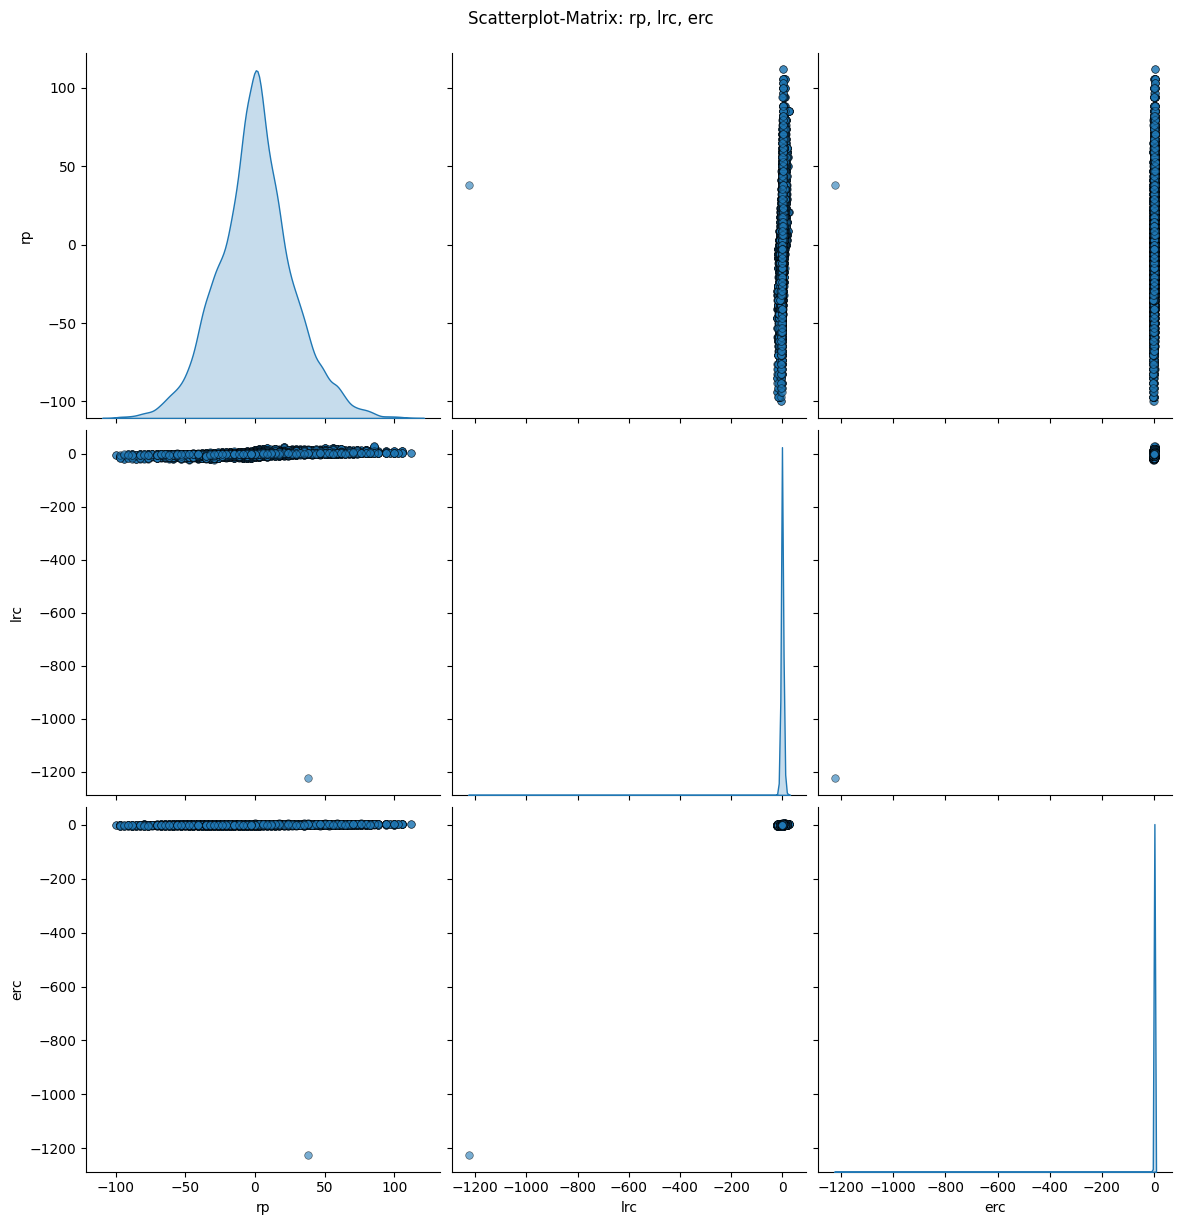

In [7]:
g = sns.pairplot(
    plot_data,
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 30, "edgecolor": "k"},
    height=4,
)
g.figure.suptitle("Scatterplot-Matrix: rp, lrc, erc", y=1.02)
plt.show()

## Prüfung auf fehlende Werte in den Modellvariablen

Vor der Modellierung wird geprüft, ob in den relevanten Feature- und Zielvariablen fehlende Werte auftreten.


In [8]:
df[df[["rp", "lrc", "erc", "matchday", "coach_dismissal"]].isna().any(axis=1)].head(30)


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position
24364,Premier League,2015,Manchester City,9,2015-10-17 18:00:00,w,8.823529,1.761914,NaN,0,0,-0.0042,1


## Behandlung fehlender Werte

Identifizierte fehlende Werte in den für die Modellierung relevanten Variablen werden durch den Wert 0 ersetzt, um eine vollständige Datenbasis für die Modellschätzung sicherzustellen. Man hätte auch den Median oder den Schnitt aus den letzte n10 Beobachtungen davor nehmen können, dass es aber für die Modellschätzung nicht wirklich etwas ausmacht und auch nur eine Beobachtung betrifft, wird einfachheitshalber 0 gewählt.

In [9]:
fill_empty_cols = ["rp", "lrc", "erc", "matchday", "coach_dismissal"]
df[fill_empty_cols] = df[fill_empty_cols].fillna(0)

## erneute Validierung

Nach der Imputation wird erneut geprüft, ob in den relevanten Modellvariablen noch fehlende Werte vorhanden sind, um die Vollständigkeit der Daten sicherzustellen.


In [10]:
df[df[fill_empty_cols].isna().any(axis=1)].head(30)

,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position


## Basismodell: Logistische Regression (balanced + scaled)

Als Basismodell wird eine logistische Regression verwendet, um die Wahrscheinlichkeit einer Trainerentlassung vorherzusagen.  

### Modellaufbau
Das Modell wird als Pipeline implementiert und besteht aus drei Schritten:
(1. **Imputation:** Fehlende Werte werden mittels Median-Imputation ersetzt.)
2. **Skalierung:** Alle numerischen Features werden standardisiert, um unterschiedliche Skalen auszugleichen.
3. **Klassifikator:** Logistische Regression mit `class_weight="balanced"` zur Berücksichtigung der Klassenungleichverteilung.

Diese Pipeline stellt sicher, dass alle Vorverarbeitungsschritte konsistent auf Trainings- und Validierungsdaten angewendet werden. Aufteilung in Saison 2014 - 2019 als Trainingsdaten und Rest sind Validierungsdaten.
Trainerentlassungen sind im Datensatz ein seltenes Ereignis. Durch die Verwendung von `class_weight="balanced"` werden Fehlklassifikationen der Minoritätsklasse stärker gewichtet, wodurch die Sensitivität des Modells erhöht wird.

## Threshold-Optimierung mittels ROC-Kurve

Da der Standard-Threshold von 0.5 für seltene Ereignisse oft ungeeignet ist, wird ein optimaler Threshold bestimmt.  
Hierzu wird das Youden-Kriterium (TPR − FPR) maximiert. Der resultierende optimale Threshold liegt bei ca. **0.45**. (Fluss, R., Faraggi, D., & Reiser, B. (2005). Estimation of the Youden Index and its associated cutoff point. Biometrical Journal: Journal of Mathematical Methods in Biosciences, 47(4), 458-472.)

## Koeffizienten

Die Koeffizienten der logistischen Regression geben Auskunft über Richtung und Stärke des Einflusses der einzelnen Variablen auf die Entlassungswahrscheinlichkeit.

Negative Koeffizienten (z.B. RP, LRC, ERC) deuten darauf hin, dass eine bessere sportliche Performance mit einer geringeren Wahrscheinlichkeit einer Trainerentlassung einhergeht.  
Der Koeffizient von `matchday` zeigt, dass sich das Entlassungsrisiko im Saisonverlauf systematisch verändert. (Die statistische Signifikanz dieser Effekte wird in einem späteren Schritt mit Statsmodels geprüft.) 
Eine ROC-AUC von ca. 0.85 weist auf eine gute Vorhersagequalität des Basismodells hin.



In [11]:
df["date"] = pd.to_datetime(df["date"], format="mixed", errors="coerce")

train_start = datetime(2014, 1, 1)
train_end = datetime(2019, 6, 30)
valid_start = datetime(2019, 7, 1)

train_df = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()
valid_df = df[df["date"] >= valid_start].copy()

print("Trainingsdaten:", train_df.shape)
print("Validierungsdaten:", valid_df.shape)

features = ["rp", "lrc", "erc", "matchday"]
target = "coach_dismissal"

X_train = train_df[features].apply(pd.to_numeric, errors="coerce")
y_train = pd.to_numeric(train_df[target], errors="coerce").fillna(0).astype(int)

X_valid = valid_df[features].apply(pd.to_numeric, errors="coerce")
y_valid = pd.to_numeric(valid_df[target], errors="coerce").fillna(0).astype(int)

print("NaNs in X_train:", X_train.isna().sum().to_dict())
print("NaNs in X_valid:", X_valid.isna().sum().to_dict())


Trainingsdaten: (18260, 13)
Validierungsdaten: (21972, 13)
NaNs in X_train: {'rp': 0, 'lrc': 0, 'erc': 0, 'matchday': 0}
NaNs in X_valid: {'rp': 0, 'lrc': 0, 'erc': 0, 'matchday': 0}



Basismodell mit class_weight=balanced
Accuracy: 0.7467231021299836
ROC-AUC: 0.8500482984067765

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.85     21695
           1       0.04      0.80      0.07       277

    accuracy                           0.75     21972
   macro avg       0.52      0.77      0.46     21972
weighted avg       0.98      0.75      0.84     21972


Optimaler Threshold: 0.449

Modell mit optimiertem Threshold
Accuracy: 0.7073548152193702
ROC-AUC bleibt = 0.8500482984067765

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     21695
           1       0.04      0.86      0.07       277

    accuracy                           0.71     21972
   macro avg       0.52      0.78      0.45     21972
weighted avg       0.99      0.71      0.82     21972


Koeffizienten:
   Variable  Koeffizient
0        rp    -0.419430
1       l

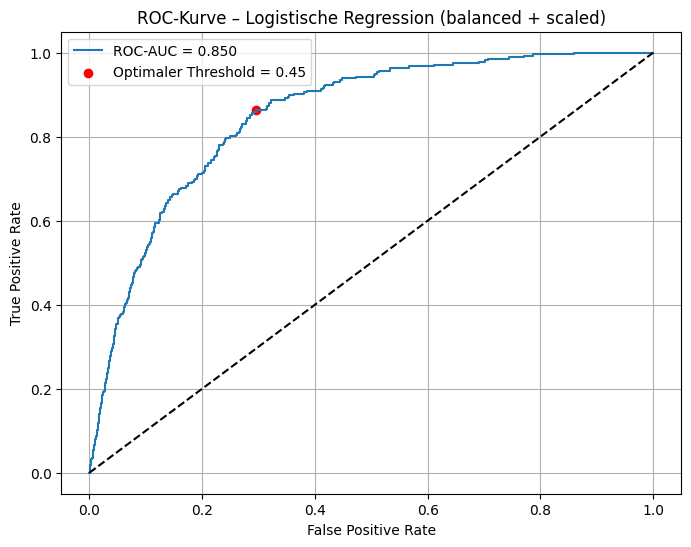

In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
        ),
    ]
)

pipe.fit(X_train, y_train)


y_prob = pipe.predict_proba(X_valid)[:, 1]
y_pred = pipe.predict(X_valid)

print()
print("Basismodell mit class_weight=balanced")
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_prob))
print()
print("Classification Report:")
print(classification_report(y_valid, y_pred))

fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
youden = tpr - fpr
idx = np.argmax(youden)
best_threshold = thresholds[idx]

print()
print(f"Optimaler Threshold: {best_threshold:.3f}")

y_pred_opt = (y_prob >= best_threshold).astype(int)

print()
print("Modell mit optimiertem Threshold")
print("Accuracy:", accuracy_score(y_valid, y_pred_opt))
print("ROC-AUC bleibt =", roc_auc_score(y_valid, y_prob))
print()
print("Classification Report:")
print(classification_report(y_valid, y_pred_opt))

coef = pipe.named_steps["logreg"].coef_[0]
coef_df = pd.DataFrame({"Variable": features, "Koeffizient": coef})
print()
print("Koeffizienten:")
print(coef_df)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_valid, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.scatter(fpr[idx], tpr[idx], color="red", label=f"Optimaler Threshold = {best_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve – Logistische Regression (balanced + scaled)")
plt.legend()
plt.grid(True)
plt.show()

## Sigmoidkurve der logistischen Regression

Die logistische Regression modelliert die Wahrscheinlichkeit einer Trainerentlassung als Sigmoidfunktion des linearen Prädiktors (Logit).  
Zur besseren Interpretation des Modells wird dieser funktionale Zusammenhang explizit visualisiert.

### Vorgehen und Ergebnisse
- Zunächst werden die Logit-Werte (lineare Kombination der standardisierten Features und der geschätzten Koeffizienten) aus der trainierten Pipeline extrahiert.
- Die zugehörigen vorhergesagten Wahrscheinlichkeiten werden den Logit-Werten gegenübergestellt.
- Zusätzlich wird die theoretische Sigmoidfunktion
\[
\sigma(z) = \frac{1}{1 + e^{-z}}
\]
über den beobachteten Logit-Bereich geplottet.
- Um den relevanten Übergangsbereich besser sichtbar zu machen, wird der Plot auf den 1.–99. Perzentilbereich der Logit-Werte gezoomt.
- Die Punktwolke der vorhergesagten Wahrscheinlichkeiten folgt der theoretischen Sigmoidkurve sehr eng.


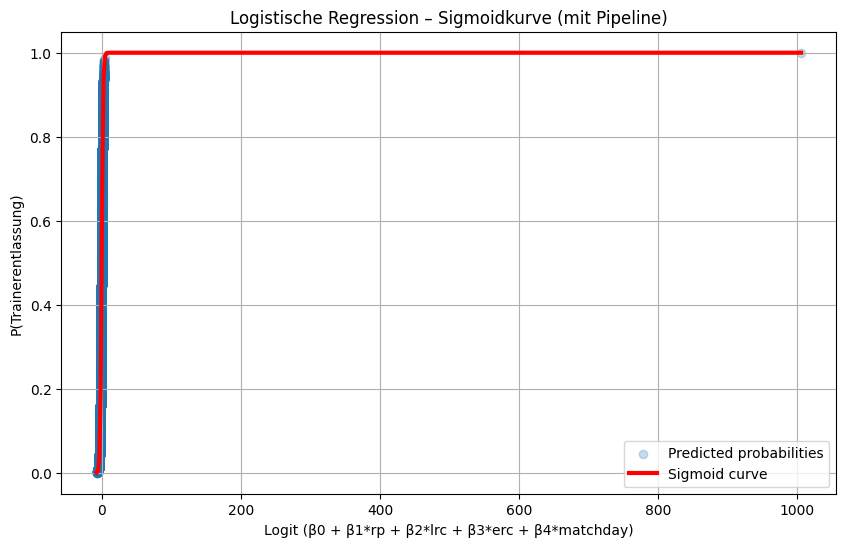

In [13]:
logit_vals = pipe.decision_function(X_valid)
prob_vals = pipe.predict_proba(X_valid)[:, 1]
sorted_idx = np.argsort(logit_vals)
logit_sorted = logit_vals[sorted_idx]
prob_sorted = prob_vals[sorted_idx]

logit_range = np.linspace(logit_vals.min(), logit_vals.max(), 500)
sigmoid_curve = 1 / (1 + np.exp(-logit_range))

plt.figure(figsize=(10, 6))
plt.scatter(logit_vals, prob_vals, alpha=0.25, label="Predicted probabilities")
plt.plot(logit_range, sigmoid_curve, "r-", linewidth=3, label="Sigmoid curve")
plt.xlabel("Logit (β0 + β1*rp + β2*lrc + β3*erc + β4*matchday)")
plt.ylabel("P(Trainerentlassung)")
plt.title("Logistische Regression – Sigmoidkurve (mit Pipeline)")
plt.grid(True)
plt.legend()
plt.show()


Logit-Bereich für Plot: -5.0137546416101415 2.447169220694336


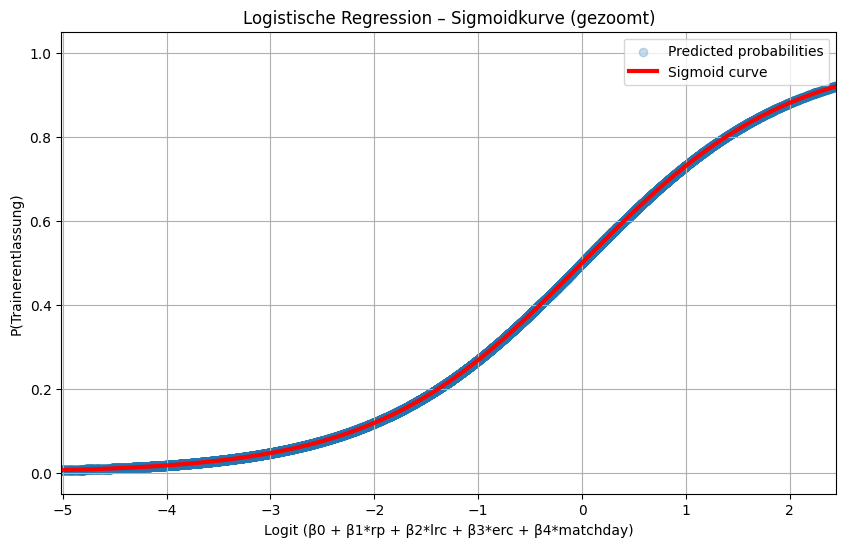

In [14]:
logit_vals = pipe.decision_function(X_valid)
prob_vals = pipe.predict_proba(X_valid)[:, 1]

low, high = np.percentile(logit_vals, [1, 99])
print("Logit-Bereich für Plot:", low, high)

logit_range = np.linspace(low, high, 500)
sigmoid_curve = 1 / (1 + np.exp(-logit_range))

plt.figure(figsize=(10, 6))
plt.scatter(logit_vals, prob_vals, alpha=0.25, label="Predicted probabilities")
plt.xlim(low, high)

plt.plot(logit_range, sigmoid_curve, "r-", linewidth=3, label="Sigmoid curve")

plt.xlabel("Logit (β0 + β1*rp + β2*lrc + β3*erc + β4*matchday)")
plt.ylabel("P(Trainerentlassung)")
plt.title("Logistische Regression – Sigmoidkurve (gezoomt)")
plt.grid(True)
plt.legend()
plt.show()


## Modellvarianten: Feature-Ablation und Vergleich alternativer Spezifikationen

Nach der Schätzung des Basismodells wird geprüft, wie stark die Vorhersageleistung von der jeweiligen Feature-Kombination abhängt.  
Hierzu werden mehrere Modellvarianten definiert, in denen jeweils unterschiedliche Teilmengen der Kernmetriken (RP, LRC, ERC) gemeinsam mit dem Spieltag (matchday) verwendet werden. Ziel ist es, den relativen Informationsgehalt einzelner Metriken zu beurteilen und potenzielle Redundanzen (besonders zwischen LRC und ERC) empirisch zu überprüfen.

Für jede Feature-Variante werden folgende Auswertungen durchgeführt:
- **Accuracy** und **ROC-AUC** auf Validierungsdaten
- **Classification Report** (Precision, Recall, F1-Score je Klasse)
- **ROC-Kurve** zur Visualisierung der Trennschärfe
- **Threshold-Optimierung** mittels Youden-Kriterium (TPR − FPR) 
- Ausgabe der **Koeffizienten** der logistischen Regression zur inhaltlichen Interpretation
- Visualisierung der **Sigmoidkurve** 


VARIANTE: rp_lrc_matchday  -> Features: ['rp', 'lrc', 'matchday']

Basismodell mit class_weight='balanced'
Accuracy: 0.7185053704715092
ROC-AUC: 0.8050268615686957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83     21695
           1       0.03      0.77      0.06       277

    accuracy                           0.72     21972
   macro avg       0.51      0.74      0.45     21972
weighted avg       0.98      0.72      0.82     21972


Optimaler Threshold: 0.498

Modell mit optimiertem Threshold
Accuracy: 0.716866921536501
ROC-AUC bleibt = 0.8050268615686957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83     21695
           1       0.03      0.78      0.06       277

    accuracy                           0.72     21972
   macro avg       0.51      0.75      0.45     21972
weighted avg       0.98      0.72      0.82     21972


Koeffi

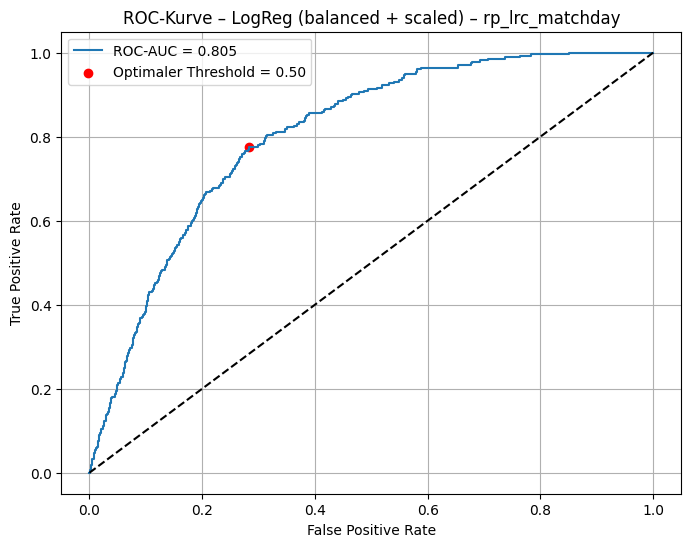

Logit-Bereich für Plot: -4.723079604447059 2.54544283327587


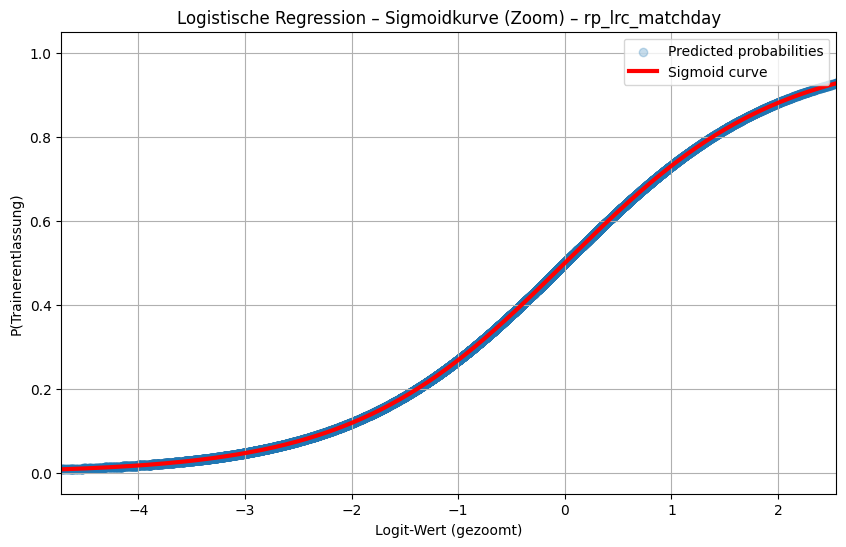


VARIANTE: rp_erc_matchday  -> Features: ['rp', 'erc', 'matchday']

Basismodell mit class_weight='balanced'
Accuracy: 0.7414436555616238
ROC-AUC: 0.8428656888284662

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     21695
           1       0.04      0.80      0.07       277

    accuracy                           0.74     21972
   macro avg       0.52      0.77      0.46     21972
weighted avg       0.98      0.74      0.84     21972


Optimaler Threshold: 0.454

Modell mit optimiertem Threshold
Accuracy: 0.7050791916985254
ROC-AUC bleibt = 0.8428656888284662

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     21695
           1       0.04      0.86      0.07       277

    accuracy                           0.71     21972
   macro avg       0.52      0.78      0.45     21972
weighted avg       0.99      0.71      0.82     21972


Koeff

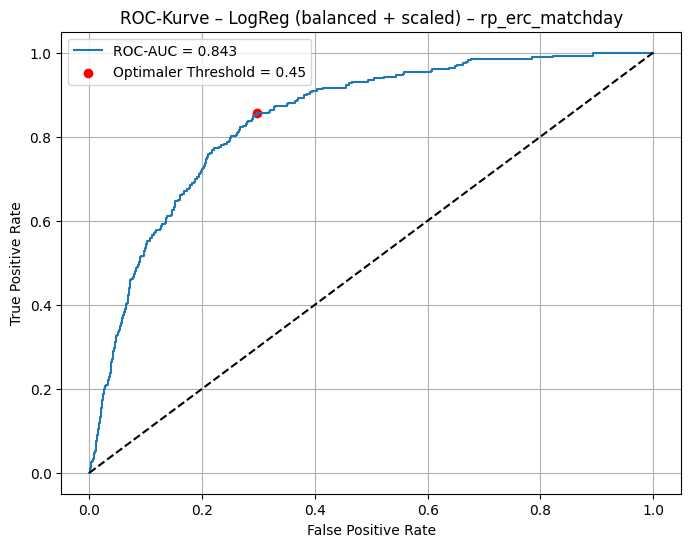

Logit-Bereich für Plot: -4.815160625432457 2.397498845820918


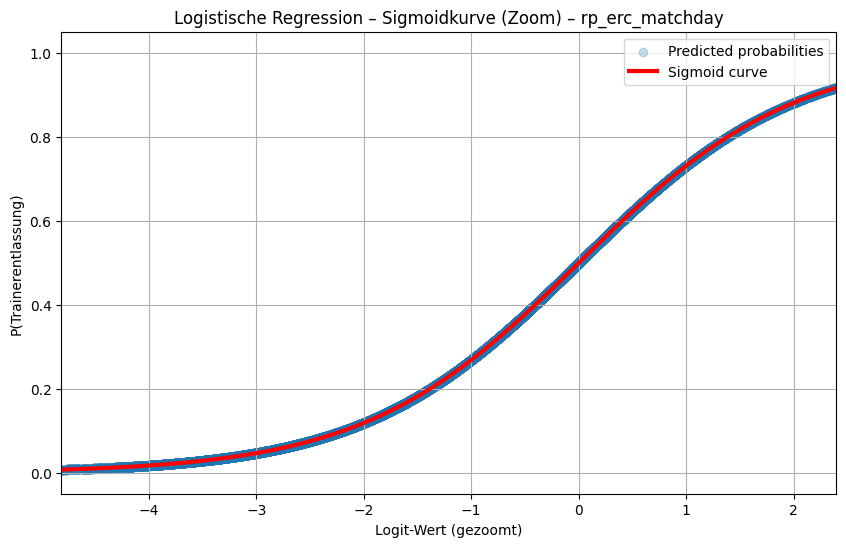


VARIANTE: lrc_erc_matchday  -> Features: ['lrc', 'erc', 'matchday']

Basismodell mit class_weight='balanced'
Accuracy: 0.7350263972328418
ROC-AUC: 0.845676065372996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85     21695
           1       0.04      0.80      0.07       277

    accuracy                           0.74     21972
   macro avg       0.52      0.77      0.46     21972
weighted avg       0.98      0.74      0.84     21972


Optimaler Threshold: 0.451

Modell mit optimiertem Threshold
Accuracy: 0.6978427089022392
ROC-AUC bleibt = 0.845676065372996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     21695
           1       0.03      0.86      0.07       277

    accuracy                           0.70     21972
   macro avg       0.52      0.78      0.44     21972
weighted avg       0.99      0.70      0.81     21972


Koeff

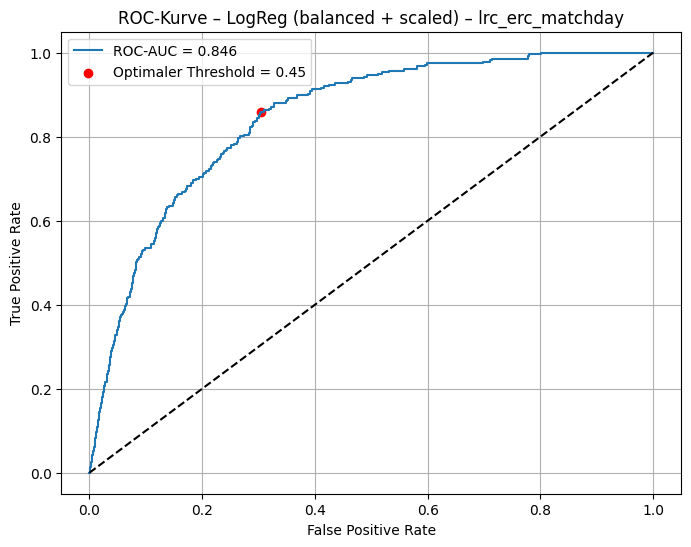

Logit-Bereich für Plot: -5.173711486902942 2.4090176093925186


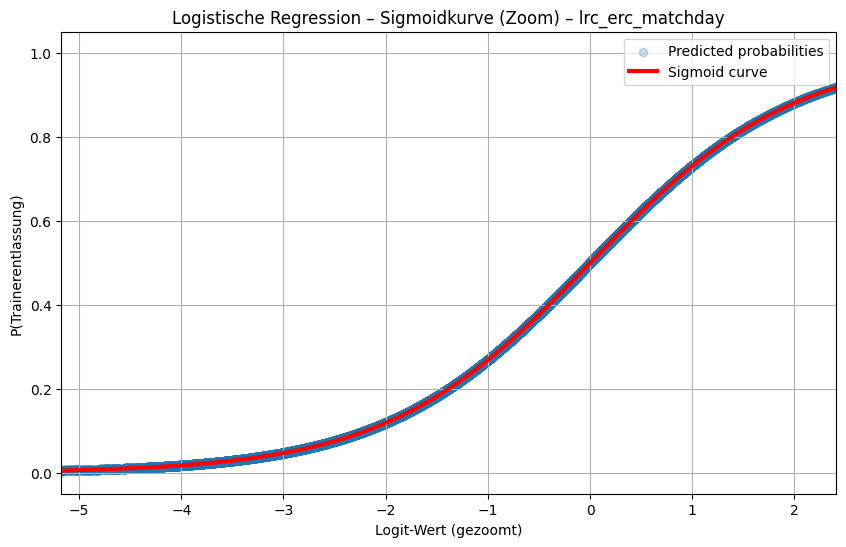

In [15]:
y_train = train_df["coach_dismissal"].astype(int)
y_valid = valid_df["coach_dismissal"].astype(int)

feature_variants = {
    "rp_lrc_matchday": ["rp", "lrc", "matchday"],
    "rp_erc_matchday": ["rp", "erc", "matchday"],
    "lrc_erc_matchday": ["lrc", "erc", "matchday"],
}

for name, feats in feature_variants.items():
    print("\n" + "=" * 80)
    print(f"VARIANTE: {name}  -> Features: {feats}")
    print("=" * 80)

    X_train_var = train_df[feats]
    X_valid_var = valid_df[feats]

    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            (
                "logreg",
                LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
            ),
        ]
    )

    pipe.fit(X_train_var, y_train)

    y_prob = pipe.predict_proba(X_valid_var)[:, 1]
    y_pred = pipe.predict(X_valid_var)

    print("\nBasismodell mit class_weight='balanced'")
    print("Accuracy:", accuracy_score(y_valid, y_pred))
    print("ROC-AUC:", roc_auc_score(y_valid, y_prob))
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred))

    fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
    youden = tpr - fpr
    idx = np.argmax(youden)
    best_threshold = thresholds[idx]

    print(f"\nOptimaler Threshold: {best_threshold:.3f}")

    y_pred_opt = (y_prob >= best_threshold).astype(int)

    print("\nModell mit optimiertem Threshold")
    print("Accuracy:", accuracy_score(y_valid, y_pred_opt))
    print("ROC-AUC bleibt =", roc_auc_score(y_valid, y_prob))
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred_opt))

    coef = pipe.named_steps["logreg"].coef_[0]
    coef_df = pd.DataFrame({"Variable": feats, "Koeffizient": coef})
    print("\nKoeffizienten:")
    print(coef_df)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_valid, y_prob):.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.scatter(
        fpr[idx],
        tpr[idx],
        color="red",
        label=f"Optimaler Threshold = {best_threshold:.2f}",
    )
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-Kurve – LogReg (balanced + scaled) – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    logit_vals = pipe.decision_function(X_valid_var)
    prob_vals = y_prob

    low, high = np.percentile(logit_vals, [1, 99])
    print("Logit-Bereich für Plot:", low, high)

    logit_range = np.linspace(low, high, 500)
    sigmoid_curve = 1 / (1 + np.exp(-logit_range))

    plt.figure(figsize=(10, 6))
    plt.scatter(logit_vals, prob_vals, alpha=0.25, label="Predicted probabilities")
    plt.xlim(low, high)
    plt.plot(logit_range, sigmoid_curve, "r-", linewidth=3, label="Sigmoid curve")

    plt.xlabel("Logit-Wert (gezoomt)")
    plt.ylabel("P(Trainerentlassung)")
    plt.title(f"Logistische Regression – Sigmoidkurve (Zoom) – {name}")
    plt.grid(True)
    plt.legend()
    plt.show()


## Ergebnis des Modellvergleichs
Vergleich der drei neukombinierten Modelle untereinander anhand von ausgewählten Metriken.


=== Trainiere Modell: rp_lrc_matchday ===

=== Trainiere Modell: rp_erc_matchday ===

=== Trainiere Modell: lrc_erc_matchday ===


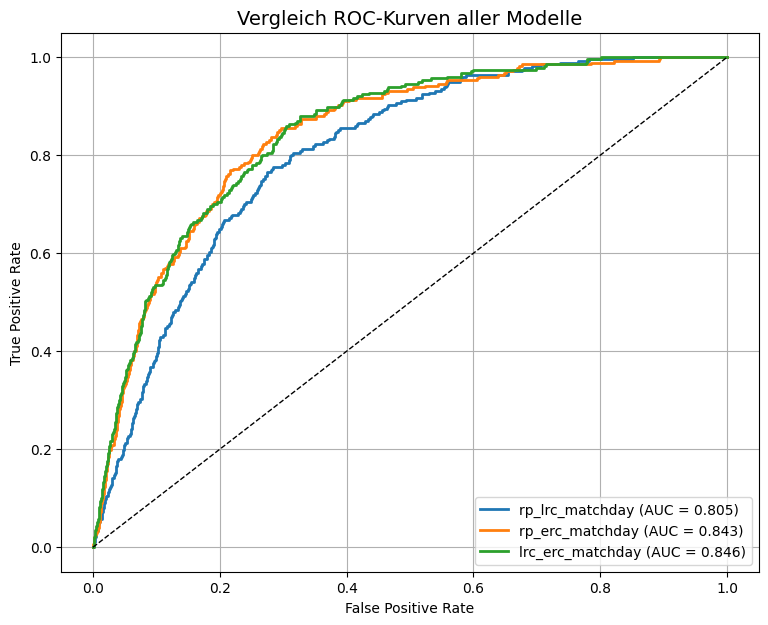

<Figure size 900x600 with 0 Axes>

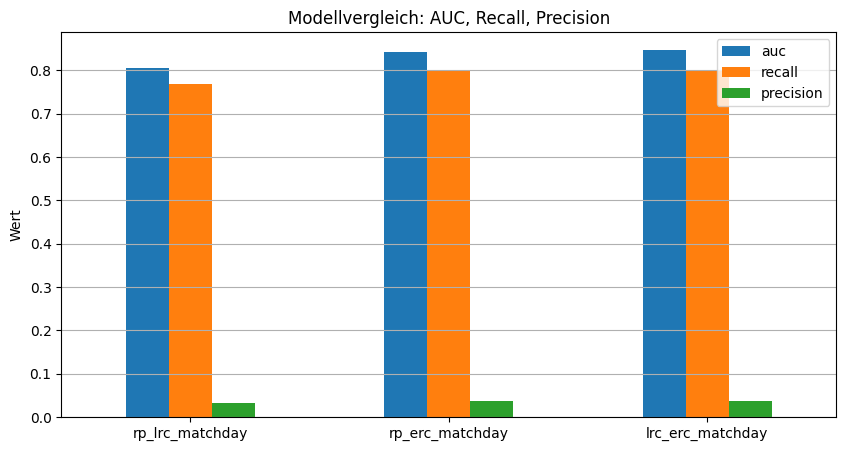

In [16]:
feature_variants = {
    "rp_lrc_matchday": ["rp", "lrc", "matchday"],
    "rp_erc_matchday": ["rp", "erc", "matchday"],
    "lrc_erc_matchday": ["lrc", "erc", "matchday"],
}

results = {}

for name, feats in feature_variants.items():
    print(f"\n=== Trainiere Modell: {name} ===")

    X_train_var = train_df[feats]
    X_valid_var = valid_df[feats]

    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            (
                "logreg",
                LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
            ),
        ]
    )

    pipe.fit(X_train_var, y_train)

    y_prob = pipe.predict_proba(X_valid_var)[:, 1]
    y_pred = pipe.predict(X_valid_var)

    fpr, tpr, _ = roc_curve(y_valid, y_prob)
    auc = roc_auc_score(y_valid, y_prob)

    results[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
        "recall": classification_report(y_valid, y_pred, output_dict=True)["1"]["recall"],
        "precision": classification_report(y_valid, y_pred, output_dict=True)["1"]["precision"],
    }

plt.figure(figsize=(9, 7))

for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], linewidth=2, label=f"{name} (AUC = {res['auc']:.3f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.title("Vergleich ROC-Kurven aller Modelle", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

metrics_df = pd.DataFrame(results).T[["auc", "recall", "precision"]]

plt.figure(figsize=(9, 6))
metrics_df.plot(kind="bar", figsize=(10, 5))
plt.title("Modellvergleich: AUC, Recall, Precision")
plt.ylabel("Wert")
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.show()


## Einzel-Feature-Modelle: jeweils eine Metrik + Spieltag

Zusätzlich zu den 3-Feature-Varianten werden vereinfachte Modelle geschätzt, die jeweils nur **eine** Performance-Metrik (RP, LRC oder ERC) gemeinsam mit `matchday` enthalten.  


=== Trainiere Modell: rp_matchday ===

=== Trainiere Modell: lrc_matchday ===

=== Trainiere Modell: erc_matchday ===


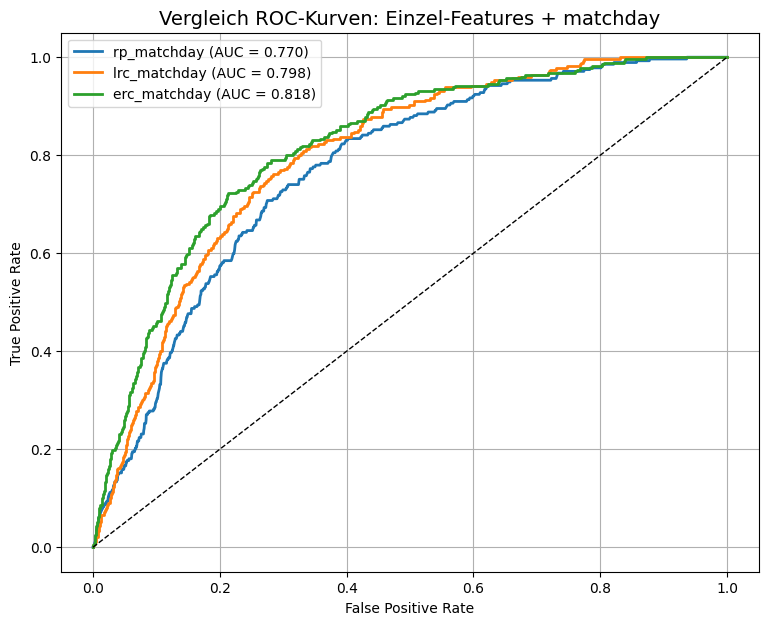

<Figure size 1000x500 with 0 Axes>

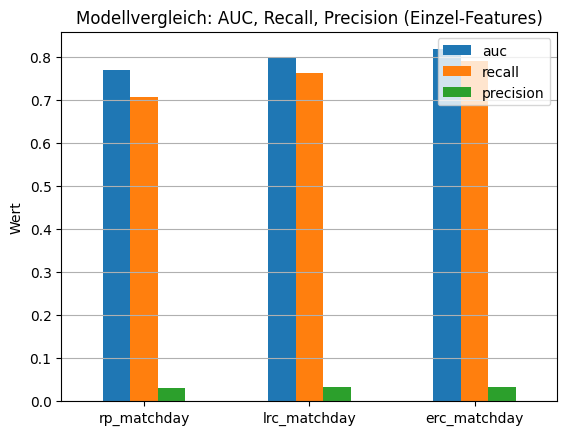

In [17]:
feature_variants = {
    "rp_matchday": ["rp", "matchday"],
    "lrc_matchday": ["lrc", "matchday"],
    "erc_matchday": ["erc", "matchday"],
}

results = {}

for name, feats in feature_variants.items():
    print(f"\n=== Trainiere Modell: {name} ===")

    X_train_var = train_df[feats]
    X_valid_var = valid_df[feats]

    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            (
                "logreg",
                LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
            ),
        ]
    )

    pipe.fit(X_train_var, y_train)

    y_prob = pipe.predict_proba(X_valid_var)[:, 1]
    y_pred = pipe.predict(X_valid_var)

    fpr, tpr, _ = roc_curve(y_valid, y_prob)
    auc = roc_auc_score(y_valid, y_prob)

    results[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
        "recall": classification_report(y_valid, y_pred, output_dict=True)["1"]["recall"],
        "precision": classification_report(y_valid, y_pred, output_dict=True)["1"]["precision"],
    }

# ROC-Kurven für alle 3 Einzel-Feature-Modelle
plt.figure(figsize=(9, 7))

for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], linewidth=2, label=f"{name} (AUC = {res['auc']:.3f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.title("Vergleich ROC-Kurven: Einzel-Features + matchday", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

metrics_df = pd.DataFrame(results).T[["auc", "recall", "precision"]]

plt.figure(figsize=(10, 5))
metrics_df.plot(kind="bar")
plt.title("Modellvergleich: AUC, Recall, Precision (Einzel-Features)")
plt.ylabel("Wert")
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.show()


## Gesamtauswertung: AUC-Vergleich aller Modellvarianten

Hier werden alle bisher geschätzten Modelle (Baseline, 3-Feature-Varianten und Einzel-Feature-Varianten) in einer gemeinsamen Übersicht anhand der **ROC-AUC** verglichen.  


=== AUC-Vergleich aller Modelle ===
                       AUC
baseline_full     0.850048
rp_lrc_matchday   0.805027
rp_erc_matchday   0.842866
lrc_erc_matchday  0.845676
rp_matchday       0.770197
lrc_matchday      0.798021
erc_matchday      0.817969


<Figure size 1000x600 with 0 Axes>

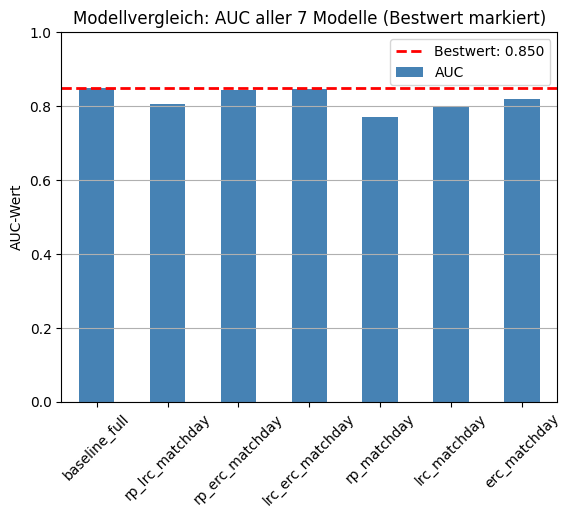

In [18]:
baseline_features = ["rp", "lrc", "erc", "matchday"]

pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
        ),
    ]
)

pipe.fit(train_df[baseline_features], y_train)
y_prob = pipe.predict_proba(valid_df[baseline_features])[:, 1]

model_results = {}
model_results["baseline_full"] = roc_auc_score(y_valid, y_prob)

feature_variants_3 = {
    "rp_lrc_matchday": ["rp", "lrc", "matchday"],
    "rp_erc_matchday": ["rp", "erc", "matchday"],
    "lrc_erc_matchday": ["lrc", "erc", "matchday"],
}

for name, feats in feature_variants_3.items():
    pipe.fit(train_df[feats], y_train)
    y_prob = pipe.predict_proba(valid_df[feats])[:, 1]
    model_results[name] = roc_auc_score(y_valid, y_prob)


feature_variants_single = {
    "rp_matchday": ["rp", "matchday"],
    "lrc_matchday": ["lrc", "matchday"],
    "erc_matchday": ["erc", "matchday"],
}

for name, feats in feature_variants_single.items():
    pipe.fit(train_df[feats], y_train)
    y_prob = pipe.predict_proba(valid_df[feats])[:, 1]
    model_results[name] = roc_auc_score(y_valid, y_prob)

auc_df = pd.DataFrame.from_dict(model_results, orient="index", columns=["AUC"])
print("\n=== AUC-Vergleich aller Modelle ===")
print(auc_df)

best_model = auc_df["AUC"].idxmax()
best_value = auc_df["AUC"].max()

plt.figure(figsize=(10, 6))
auc_df.plot(kind="bar", legend=False, color="steelblue")
plt.axhline(
    y=best_value,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Bestwert: {best_value:.3f}",
)

plt.title("Modellvergleich: AUC aller 7 Modelle (Bestwert markiert)")
plt.ylabel("AUC-Wert")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Signifikanzanalyse mit statsmodels: Logit-Modelle für verschiedene Feature-Sets

Nachdem die Modellvarianten hinsichtlich ihrer Vorhersagegüte (z.B. ROC-AUC) verglichen wurden, wird im nächsten Schritt eine sogenannte "inferenzstatistische" Auswertung der Modelle vorgenommen.  
Hierzu werden die gleichen Feature-Sets mit **statsmodels** als Logit-Modelle geschätzt, um **Koeffizienten, Standardfehler, p-Werte und Konfidenzintervalle** zu erhalten. Ziel ist es, die statistische Signifikanz einzelner Einflussfaktoren zu beurteilen und die Interpretierbarkeit der Modelle zu erhöhen.


In [19]:
feature_sets = {
    "Basismodell": ["rp", "lrc", "erc", "matchday"],
    "rp + matchday": ["rp", "matchday"],
    "lrc + matchday": ["lrc", "matchday"],
    "erc + matchday": ["erc", "matchday"],
    "rp + lrc + matchday": ["rp", "lrc", "matchday"],
    "rp + erc + matchday": ["rp", "erc", "matchday"],
    "erc + lrc + matchday": ["erc", "lrc", "matchday"],
}

y_var = "coach_dismissal"

for name, x_vars in feature_sets.items():
    print("\n" + "=" * 80)
    print(f"MODELL: {name}")
    print("=" * 80)

    team_data = df.copy()

    team_data = team_data.dropna(subset=x_vars + [y_var])

    train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
    train_data = team_data[team_data["year"].isin(train_seasons)]
    test_data = team_data[~team_data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var]

    model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)

    print(model.summary())



MODELL: Basismodell
                           Logit Regression Results                           
Dep. Variable:        coach_dismissal   No. Observations:                21710
Model:                          Logit   Df Residuals:                    21705
Method:                           MLE   Df Model:                            4
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                  0.1677
Time:                        14:12:28   Log-Likelihood:                -1270.7
converged:                       True   LL-Null:                       -1526.7
Covariance Type:            nonrobust   LLR p-value:                1.760e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0993      0.159    -32.028      0.000      -5.411      -4.787
rp            -0.0103      0.003     -3.448      0.001      -0.016      -0.004
lrc           -0.0988      0.01

## Konstruktion alternativer Zielvariablen: Spiele *nach* einer Trainerentlassung (After-Window)

Neben der ursprünglichen Zielvariable `coach_dismissal` wird eine alternative Target-Definition eingeführt, um mögliche Effekte **unmittelbar nach einer Entlassung** zu untersuchen.  
Dazu wird eine Indikatorvariable konstruiert, die markiert, ob ein Spiel zu den ersten \(k\) Spielen **nach** einer Entlassung gehört (z.B. \(k=3\) bzw. \(k=5\)).

- \(window = 3\): Modell für die ersten drei Spiele nach einer Entlassung (d.h Entlassung + 3 Spiele danach)
- \(window = 5\): Modell für die ersten fünf Spiele nach einer Entlassung (d.h Entlassung + 5 Spiele danach)


In [20]:
def add_coach_dismissal_after(df, window, new_col):
    df = df.sort_values(by=["team", "year", "matchday"]).copy()
    df[new_col] = 0

    for (team, year), group in df.groupby(["team", "year"], sort=False):
        group = group.sort_values("matchday")
        idx_list = list(group.index)

        for i, idx in enumerate(idx_list):
            if group.loc[idx, "coach_dismissal"] == 1:
                start = i + 1
                end = min(len(idx_list), i + 1 + window)
                to_mark = idx_list[start:end]
                df.loc[to_mark, new_col] = 1

    return df


def fit_logit_after_window(df, window):
    # Name der Zielvariable z.B. coach_dismissal_after_3 / _5
    y_var = f"coach_dismissal_after_{window}"

    # Variable erzeugen
    df_with_flag = add_coach_dismissal_after(df, window, y_var)

    x_vars = ["rp", "lrc", "erc", "matchday"]

    team_data = df_with_flag.dropna(subset=x_vars + [y_var])

    train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
    train_data = team_data[team_data["year"].isin(train_seasons)]
    test_data = team_data[~team_data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var]

    model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
    print(f"\n=== Logit-Modell für {window} Spiele nach Entlassung ===")
    print(model.summary())
    return model, df_with_flag


# Aufruf für 3 und 5 Spiele:
model_after_3, df = fit_logit_after_window(df, window=3)
model_after_5, df = fit_logit_after_window(df, window=5)


Optimization terminated successfully.
         Current function value: 0.142833
         Iterations 8

=== Logit-Modell für 3 Spiele nach Entlassung ===
                              Logit Regression Results                             
Dep. Variable:     coach_dismissal_after_3   No. Observations:                21710
Model:                               Logit   Df Residuals:                    21705
Method:                                MLE   Df Model:                            4
Date:                     Tue, 23 Dec 2025   Pseudo R-squ.:                  0.1317
Time:                             14:12:30   Log-Likelihood:                -3100.9
converged:                            True   LL-Null:                       -3571.4
Covariance Type:                 nonrobust   LLR p-value:                2.233e-202
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.

## Konstruktion alternativer Zielvariablen: Spiele *vor* einer Trainerentlassung (Before-Window)

Ergänzend zur Analyse der Post-Entlassungs-Phase wird eine alternative Zielvariable definiert, die Spiele im unmittelbaren Vorfeld einer Trainerentlassung markiert.  

In [21]:
def add_coach_dismissal_before(df, window, new_col):
    df = df.sort_values(by=["team", "year", "matchday"]).copy()
    df[new_col] = 0

    for (team, year), group in df.groupby(["team", "year"], sort=False):
        group = group.sort_values("matchday")
        idx_list = list(group.index)

        for i, idx in enumerate(idx_list):
            if group.loc[idx, "coach_dismissal"] == 1:
                start = max(0, i - window)
                to_mark = idx_list[start:i]  # Spiele VOR der Entlassung
                df.loc[to_mark, new_col] = 1

    return df


def fit_logit_before_window(df, window):
    y_var = f"coach_dismissal_before_{window}"

    df_with_flag = add_coach_dismissal_before(df, window, y_var)

    x_vars = ["rp", "lrc", "erc", "matchday"]

    team_data = df_with_flag.dropna(subset=x_vars + [y_var])

    train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
    train_data = team_data[team_data["year"].isin(train_seasons)]
    test_data = team_data[~team_data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var]

    model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
    print(f"\n=== Logit-Modell für {window} Spiele VOR Entlassung ===")
    print(model.summary())

    return model, df_with_flag


model_before_3, df = fit_logit_before_window(df, window=3)
model_before_5, df = fit_logit_before_window(df, window=5)


Optimization terminated successfully.
         Current function value: 0.145653
         Iterations 8

=== Logit-Modell für 3 Spiele VOR Entlassung ===
                              Logit Regression Results                              
Dep. Variable:     coach_dismissal_before_3   No. Observations:                21710
Model:                                Logit   Df Residuals:                    21705
Method:                                 MLE   Df Model:                            4
Date:                      Tue, 23 Dec 2025   Pseudo R-squ.:                  0.1090
Time:                              14:12:31   Log-Likelihood:                -3162.1
converged:                             True   LL-Null:                       -3548.9
Covariance Type:                  nonrobust   LLR p-value:                4.173e-166
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

## Zeit seit der letzten Trainerentlassung

In diesem Schritt wird eine zusätzliche erklärende Variable konstruiert, die den zeitlichen Abstand zur letzten Trainerentlassung misst. (saisonübergreifend, nur teamweise getrennt)  
Ziel ist es, mögliche **zeitabhängige Effekte** zu erfassen, etwa ob kürzlich erfolgte Entlassungen mit einer erhöhten Wahrscheinlichkeit weiterer personeller Veränderungen einhergehen.

Da die Anzahl der Tage stark streuen kann und sehr große Werte annehmen kann, wird zusätzlich eine logarithmische Transformation angewendet:
\[
\text{log\_since\_last\_dismissal\_in\_days} = \log(\text{since\_last\_dismissal\_in\_days} + 1)
\]

Diese Transformation reduziert die Wirkung extremer Werte und führt zu einer besser skalierten, modellfreundlichen Variable.

In [22]:
df["date"] = pd.to_datetime(df["date"])

df["since_last_dismissal_in_days"] = 0
df["log_since_last_dismissal_in_days"] = 0.0

for team, group in df.groupby("team", sort=False):
    group = group.sort_values(["year", "matchday"])

    values = []
    last_dismissal_date = None
    first_row = True

    for idx, row in group.iterrows():
        if first_row:
            values.append(0)
            first_row = False

            if row["coach_dismissal"] == 1:
                last_dismissal_date = row["date"]

            continue

        if row["coach_dismissal"] == 1:
            if last_dismissal_date is None:
                tage = (row["date"] - group.iloc[0]["date"]).days
            else:
                tage = (row["date"] - last_dismissal_date).days

            values.append(tage)
            last_dismissal_date = row["date"]  # Reset

        else:
            if last_dismissal_date is None:
                tage = (row["date"] - group.iloc[0]["date"]).days
            else:
                tage = (row["date"] - last_dismissal_date).days

            values.append(tage)

    df.loc[group.index, "since_last_dismissal_in_days"] = values

df["log_since_last_dismissal_in_days"] = (df["since_last_dismissal_in_days"] + 1).apply(np.log)

df.head(40)


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position,coach_dismissal_after_3,coach_dismissal_after_5,coach_dismissal_before_3,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,0,-1.6627,1,0,0,0,0,0,0.000000
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,0,-0.2475,1,0,0,0,0,14,2.708050
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,1,0.3653,4,0,0,0,0,20,3.044522
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,2,-0.6323,7,0,0,0,0,23,3.178054
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,3,0.0364,6,0,0,0,0,27,3.332205
31777,Serie A,2014,AC Milan,6,2014-10-04 19:45:00,w,8.823529,0.766854,-0.043507,0,0,-0.8131,5,0,0,0,0,34,3.555348
31778,Serie A,2014,AC Milan,7,2014-10-19 14:00:00,w,14.705882,2.148433,1.354690,0,0,-1.0824,4,0,0,0,0,48,3.891820
31779,Serie A,2014,AC Milan,8,2014-10-26 19:45:00,d,2.941176,1.489914,0.178726,0,1,0.8144,6,0,0,0,0,56,4.043051
31780,Serie A,2014,AC Milan,9,2014-10-29 19:45:00,d,14.705882,0.871493,-0.507962,0,2,-0.6245,4,0,0,0,0,59,4.094345
31781,Serie A,2014,AC Milan,10,2014-11-02 19:45:00,l,-2.941176,-1.252102,-2.437533,0,3,0.9358,7,0,0,0,0,63,4.158883


## Zeit seit der letzten Trainerentlassung (saisonal zurückgesetzt)

Neben der teamübergreifend fortgeschriebenen Variante wird eine zweite Version der Zeitvariablen konstruiert, die **zu Beginn jeder Saison zurückgesetzt** wird.  
Ziel ist es, die „Zeit seit letzter Entlassung“ **innerhalb einer Saison** zu messen und damit saisonale Brüche (Sommerpause, Trainerwechsel zwischen Saisons) methodisch zu berücksichtigen. 
Interessant hierbei zu nennen ist die Tatsache, dass Trainerwechsel nach einer Saison nicht im Datensatz berücksichtigt werden (oft sind diese auch nicht wirklich freiwillig gewesen, sondern man einigt sich darauf den Vertrag auslaufen zu lassen). Beispiel Wechsel Pep Guardiola und Carlo Ancelotti 2016 zu 2017. Ebenso wurde nicht im Datensatz berücksichtigt, dass Ancelotti nach dem Champions League Spiel und nicht in dem Bundesligaspiel entlassen wurde.


In [23]:
df["date"] = pd.to_datetime(df["date"])
df["since_last_dismissal_in_days_seasonal"] = 0

for (team, year), group in df.groupby(["team", "year"], sort=False):
    group = group.sort_values(["matchday"])
    values = []
    last_dismissal_date = None

    for idx, row in group.iterrows():
        if row["matchday"] == 1:
            values.append(0)

            if row["coach_dismissal"] == 1:
                last_dismissal_date = row["date"]

            continue

        if row["coach_dismissal"] == 1:
            if last_dismissal_date is None:
                tage = (row["date"] - group.iloc[0]["date"]).days
            else:
                tage = (row["date"] - last_dismissal_date).days

            values.append(tage)
            last_dismissal_date = row["date"]

        else:
            if last_dismissal_date is None:
                tage = (row["date"] - group.iloc[0]["date"]).days
            else:
                tage = (row["date"] - last_dismissal_date).days

            values.append(tage)

    df.loc[group.index, "since_last_dismissal_in_days_seasonal"] = values

df.head()


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,winless_streak,xpts_diff,table_position,coach_dismissal_after_3,coach_dismissal_after_5,coach_dismissal_before_3,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days,since_last_dismissal_in_days_seasonal
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,0,-1.6627,1,0,0,0,0,0,0.000000,0
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,0,-0.2475,1,0,0,0,0,14,2.708050,14
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,1,0.3653,4,0,0,0,0,20,3.044522,20
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,2,-0.6323,7,0,0,0,0,23,3.178054,23
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,3,0.0364,6,0,0,0,0,27,3.332205,27


## Niederlagenserie „Loss-in-Strike“

Zusätzlich zu den leistungs- und zeitbasierten Variablen wird eine weitere erklärende Variable konstruiert, die die Länge einer aktuellen **Niederlagenserie** abbildet.  Die Variable `loss_in_strike` misst kurzfristigen Leistungsdruck und ergänzt damit die eher langfristig orientierten Performance-Metriken (RP, LRC, ERC).  Im Gegensatz zur Variable winless_Streak werden hier nur die Niederlagen in Folge betrachtet und nicht auch noch Unentschieden dazugezählt.


In [24]:
df = df.sort_values(by=["team", "year", "matchday"])

df["loss_in_strike"] = 0

for (team, year), group in df.groupby(["team", "year"], sort=False):
    group = group.sort_values("matchday")
    loss_count = 0
    values = []

    for idx, row in group.iterrows():
        if str(row["result"]).lower().startswith("l"):
            loss_count += 1
        else:
            loss_count = 0

        values.append(loss_count)

    df.loc[group.index, "loss_in_strike"] = values
df.head()


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,xpts_diff,table_position,coach_dismissal_after_3,coach_dismissal_after_5,coach_dismissal_before_3,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days,since_last_dismissal_in_days_seasonal,loss_in_strike
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,-1.6627,1,0,0,0,0,0,0.000000,0,0
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,-0.2475,1,0,0,0,0,14,2.708050,14,0
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,0.3653,4,0,0,0,0,20,3.044522,20,1
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,-0.6323,7,0,0,0,0,23,3.178054,23,0
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,0.0364,6,0,0,0,0,27,3.332205,27,0


## Tage seit dem letzten Spiel „Days Since Break“

In diesem Schritt wird eine zusätzliche zeitliche Variable konstruiert, die den Abstand in Tagen zwischen zwei aufeinanderfolgenden Spielen misst. Die Variable `days_since_break` erlaubt es, Spielpausen explizit zu berücksichtigen.  



In [25]:
df["date"] = pd.to_datetime(df["date"])

df["days_since_break"] = 0

for (team, year), group in df.groupby(["team", "year"], sort=False):
    group = group.sort_values("matchday")
    values = []
    last_date = None

    for idx, row in group.iterrows():
        if last_date is None:
            values.append(0)
            last_date = row["date"]
            continue

        diff_days = (row["date"] - last_date).days
        values.append(diff_days)

        last_date = row["date"]

    df.loc[group.index, "days_since_break"] = values
df.head()

,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,table_position,coach_dismissal_after_3,coach_dismissal_after_5,coach_dismissal_before_3,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days,since_last_dismissal_in_days_seasonal,loss_in_strike,days_since_break
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,1,0,0,0,0,0,0.000000,0,0,0
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,1,0,0,0,0,14,2.708050,14,0,14
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,4,0,0,0,0,20,3.044522,20,1,6
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,7,0,0,0,0,23,3.178054,23,0,3
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,6,0,0,0,0,27,3.332205,27,0,4


## Spielpausen und Saisonunterbrechungen

Ergänzend zur reinen Berechnung der Tage seit dem letzten Spiel wird eine binäre Variable eingeführt, die längere Unterbrechungen zwischen zwei Spielen explizit kennzeichnet. Überschreitet diese Differenz einen vordefinierten Schwellenwert (`BREAK_THRESHOLD = 10` Tage), wird `is_season_break` auf 1 gesetzt, andernfalls auf 0. (10 Tage da wenn normale Spieltag dann ist die maximale Zeit zwischen zwei Spieltagen 9 Tage, da Freitag bis kommender Sonntag größte Tagesspanne ist). Winterpausen oder Länderspielpausen werden im Fußball insbesondere für geplante Entlassunge genutzt, da für den neuen Trainer etwas mehr Zeit zur Vorbereitung besteht.

In [26]:
df = df.sort_values(by=["team", "year", "matchday"])
df["date"] = pd.to_datetime(df["date"])

df["days_since_break"] = 0
df["is_season_break"] = 0

BREAK_THRESHOLD = 10  # >10 Tage = Saisonpause

for team, group in df.groupby("team", sort=False):
    group = group.sort_values(["year", "matchday"])
    idx_list = group.index.tolist()

    previous_date = None

    for i, idx in enumerate(idx_list):
        current_date = group.loc[idx, "date"]

        if previous_date is None:
            df.loc[idx, "days_since_break"] = 0
            df.loc[idx, "is_season_break"] = 0
        else:
            diff = (current_date - previous_date).days
            df.loc[idx, "days_since_break"] = diff

            df.loc[idx, "is_season_break"] = 1 if diff > BREAK_THRESHOLD else 0

        previous_date = current_date
df.head()

,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,coach_dismissal_after_3,coach_dismissal_after_5,coach_dismissal_before_3,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days,since_last_dismissal_in_days_seasonal,loss_in_strike,days_since_break,is_season_break
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,0,0,0,0,0,0.000000,0,0,0,0
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,0,0,0,0,14,2.708050,14,0,14,1
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,0,0,0,0,20,3.044522,20,1,6,0
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,0,0,0,0,23,3.178054,23,0,3,0
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,0,0,0,0,27,3.332205,27,0,4,0


## Formtrend auf Basis der erwarteten Punktedifferenz

In diesem Schritt wird eine weitere erklärende Variable konstruiert, die den **kurzfristigen Formtrend** eines Teams abbildet.  
Als Grundlage dient die Variable `xpts_diff`, welche die Differenz zwischen tatsächlich erreichten und erwarteten Punkten eines Spiels misst. Für jedes Team und jede Saison wird separat ein gleitender Durchschnitt (`rolling mean`) der Variable `xpts_diff` berechnet. Der Formtrend fasst die jüngste Leistungsentwicklung eines Teams über mehrere Spiele zusammen und glättet zufällige Spielschwankungen.  


In [ ]:
WINDOW = 3  # oder 5

df = df.sort_values(by=["team", "year", "matchday"])

df[f"form_trend_{WINDOW}"] = 0.0

for (team, year), group in df.groupby(["team", "year"], sort=False):
    group = group.sort_values(["matchday"])
    idx_list = group.index.tolist()

    rolling_vals = group["xpts_diff"].rolling(window=WINDOW, min_periods=1).mean()

    df.loc[idx_list, f"form_trend_{WINDOW}"] = rolling_vals.values

df.head()


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,loss_in_strike,days_since_break,is_season_break,form_trend_3,points_match,points_season_cum,points_gap_to_leader,points_gap_to_cl,points_gap_to_relegation,form_trend_5
0,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,0,0,0,-1.662700,3.0,3.0,0.0,0.0,3.0,-1.662700
1,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,0,14,1,-0.955100,3.0,6.0,0.0,0.0,5.0,-0.955100
2,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,1,6,0,-0.514967,0.0,6.0,3.0,0.0,5.0,-0.514967
3,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,0,3,0,-0.171500,1.0,7.0,5.0,1.0,4.0,-0.544300
4,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,0,4,0,-0.076867,1.0,8.0,7.0,3.0,5.0,-0.428160


## Berechnung von Spielpunkten und kumulierten Saisonpunkten

In diesem Schritt werden aus den Spielergebnissen die **Punkte pro Spiel** berechnet und anschließend zu einem **kumulierten Punktestand pro Saison** aggregiert. Die Variable `points_season_cum` bildet den **aktuellen Tabellenpunktestand eines Teams zu jedem Spieltag** ab.  
Sie dient als zentrale Grundlage für weitere kontextuelle Features wie den **Punkteabstand zum Tabellenführer**, zur **Champions-League-Zone** oder zur **Abstiegszone**.

In [28]:
# Punkte pro Spiel (W=3, D=1, L=0) und kumulierte Saisonpunkte je Team
df = df.sort_values(["team", "year", "matchday"]).copy()
res = df["result"].astype(str).str.strip().str.lower()

df["points_match"] = np.select(
    [res.str.startswith("w"), res.str.startswith("d"), res.str.startswith("l")],
    [3, 1, 0],
    default=np.nan,
)
df["points_season_cum"] = df.groupby(["team", "year"], sort=False)["points_match"].cumsum()
df.head()

,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,coach_dismissal_before_5,since_last_dismissal_in_days,log_since_last_dismissal_in_days,since_last_dismissal_in_days_seasonal,loss_in_strike,days_since_break,is_season_break,form_trend_3,points_match,points_season_cum
31772,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,0,0,0.000000,0,0,0,0,-1.662700,3.0,3.0
31773,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,0,14,2.708050,14,0,14,1,-0.955100,3.0,6.0
31774,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,0,20,3.044522,20,1,6,0,-0.514967,0.0,6.0
31775,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,0,23,3.178054,23,0,3,0,-0.171500,1.0,7.0
31776,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,0,27,3.332205,27,0,4,0,-0.076867,1.0,8.0


## Berechnung kontextueller Punkteabstände (Meister, Champions League, Abstiegszone)

Auf Basis der zuvor berechneten kumulierten Saisonpunkte (`points_season_cum`) werden in diesem Schritt **drei kontextuelle Abstandsvariablen** konstruiert, die die sportliche Situation eines Teams an jedem Spieltag präzise abbilden.  
Alle Berechnungen erfolgen **spieltagsspezifisch innerhalb einer Saison und Liga** (`league`, `year`, `matchday`).

### 1) Punkteabstand zum Tabellenführer

- Für jeden Spieltag wird die maximale Punktzahl innerhalb der Liga als Punktestand des Tabellenführers bestimmt.
- Der **Punkteabstand zum Leader** (`points_gap_to_leader`) ergibt sich als Differenz zwischen den Punkten des Tabellenführers und den eigenen Saisonpunkten.

### 2) Punkteabstand zur Champions-League-Zone

- Die Champions-League-Zone wird unabhängig vom offiziellen Tabellenplatz **über die vier punktbesten Teams** eines Spieltags definiert.
- Hierzu wird ein Punkterang (`rank_points`) auf Basis der Saisonpunkte gebildet.
- Der Punktestand des viertbesten Teams dient als **Champions-League-Schwelle**.
- Die Abstandsvariable `points_gap_to_cl` ist definiert als:
  - **0**, falls sich ein Team auf Tabellenplatz 1–4 befindet  
  - ansonsten die fehlenden Punkte zur Champions-League-Schwelle

### 3) Punkteabstand zur Abstiegszone

- Die Abstiegsgrenze wird **ligaspezifisch** definiert:
  - Bundesliga: Platz 16  
  - Alle anderen betrachteten Ligen: Platz 18
- Für jeden Spieltag wird der Punktestand des Teams auf der jeweiligen Cutoff-Position bestimmt.
- Der **Abstand zur Abstiegszone** (`points_gap_to_relegation`) ist definiert als:
  - **0**, wenn sich das Team auf oder unterhalb der Abstiegsgrenze befindet  
  - ansonsten das Punktpolster gegenüber der Abstiegszone



In [ ]:
df = df.copy()
df["table_position"] = pd.to_numeric(df["table_position"], errors="coerce")
df["points_season_cum"] = pd.to_numeric(df["points_season_cum"], errors="coerce")

grp = ["league", "year", "matchday"]

# Clean
cols_to_drop = [
    "leader_points",
    "rank_points",
    "cl4_points",
    "releg_cutoff_pos",
    "releg_cutoff_points",
    "releg_cutoff_points_x",
    "releg_cutoff_points_y",
    "points_gap_to_leader",
    "points_gap_to_cl",
    "points_gap_to_relegation",
]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors="ignore")

# 1) Abstand zum Tabellenführer
df["leader_points"] = df.groupby(grp)["points_season_cum"].transform("max")
df["points_gap_to_leader"] = df["leader_points"] - df["points_season_cum"]

# 2) CL-Abstand
df["rank_points"] = df.groupby(grp)["points_season_cum"].rank(method="first", ascending=False)

df["cl4_points"] = df["points_season_cum"].where(df["rank_points"] == 4)
df["cl4_points"] = df.groupby(grp)["cl4_points"].transform("max")
df["cl4_points"] = df["cl4_points"].fillna(df.groupby(grp)["points_season_cum"].transform("min"))

df["points_gap_to_cl"] = np.where(
    df["table_position"].le(4), 0.0, (df["cl4_points"] - df["points_season_cum"]).clip(lower=0)
)

# 3) Relegations-/Abstiegsabstand
releg_cutoff = {
    "Bundesliga": 16,
    "La Liga": 18,
    "Premier League": 18,
    "Serie A": 18,
    "Ligue 1": 18,
}
df["releg_cutoff_pos"] = df["league"].map(releg_cutoff)

# Punkte je Tabellenplatz pro Spieltag
pos_points = (
    df.groupby(grp + ["table_position"], as_index=False)["points_season_cum"]
    .min()
    .rename(columns={"points_season_cum": "pos_points"})
)

# cutoff-points je Zeile
cutoff_points = (
    df[grp + ["releg_cutoff_pos"]]
    .drop_duplicates()
    .merge(
        pos_points,
        left_on=grp + ["releg_cutoff_pos"],
        right_on=grp + ["table_position"],
        how="left",
    )
    .rename(columns={"pos_points": "releg_cutoff_points"})
    .drop(columns=["table_position"])
)

df = df.merge(cutoff_points, on=grp + ["releg_cutoff_pos"], how="left")

df["points_gap_to_relegation"] = np.where(
    df["table_position"].ge(df["releg_cutoff_pos"]),
    0.0,
    (df["points_season_cum"] - df["releg_cutoff_points"]).clip(lower=0),
)

# Hilfspalten weg
df.drop(
    columns=["leader_points", "rank_points", "cl4_points", "releg_cutoff_pos", "releg_cutoff_points"],
    inplace=True,
    errors="ignore",
)

df.head()


,league,year,team,matchday,date,result,rp,lrc,erc,coach_dismissal,...,since_last_dismissal_in_days_seasonal,loss_in_strike,days_since_break,is_season_break,form_trend_3,points_match,points_season_cum,points_gap_to_leader,points_gap_to_cl,points_gap_to_relegation
0,Serie A,2014,AC Milan,1,2014-08-31 17:00:00,w,32.352941,1.308688,1.308688,0,...,0,0,0,0,-1.662700,3.0,3.0,0.0,0.0,3.0
1,Serie A,2014,AC Milan,2,2014-09-14 19:45:00,w,32.352941,2.935043,2.435169,0,...,14,0,14,1,-0.955100,3.0,6.0,0.0,0.0,5.0
2,Serie A,2014,AC Milan,3,2014-09-20 19:45:00,l,14.705882,1.764703,0.334678,0,...,20,1,6,0,-0.514967,0.0,6.0,3.0,0.0,5.0
3,Serie A,2014,AC Milan,4,2014-09-23 19:45:00,d,-2.941176,0.958863,-0.598998,0,...,23,0,3,0,-0.171500,1.0,7.0,5.0,1.0,4.0
4,Serie A,2014,AC Milan,5,2014-09-28 14:00:00,d,2.941176,-0.028921,-1.357985,0,...,27,0,4,0,-0.076867,1.0,8.0,7.0,3.0,5.0


## Erweiterte Logit-Modelle zur Vorhersage von Trainerentlassungen - Feature-Set inkl. weitere Kontextvariablen

In diesem Schritt wird ein erweitertes logistisches Regressionsmodell (Logit) mit `statsmodels` geschätzt, das die Zielvariable `coach_dismissal` vorhersagt.  
Im Vergleich zu den Basismodellen werden neben den Kernmetriken (RP, LRC, ERC) zusätzliche Features integriert, die kurzfristige Form, zeitliche Dynamik und tabellarischen Kontext abbilden.
Die Funktion `fit_logit_coach_dismissal()` schätzt ein Logit-Modell mit folgenden erklärenden Variablen:

- **Performance-Metriken:** `rp`, `lrc`, `erc`
- **Saisonfortschritt:** `matchday`
- **Zeit seit letzter Entlassung (log-transformiert):** `log_since_last_dismissal_in_days`
- **Niederlagenserie:** `loss_in_strike`
- **Formtrend über ein Fenster von `window` Spielen:** `form_trend_{window}`
- **Saisonpause-Indikator:** `is_season_break`
- **Tabellenkontext (Punkteabstände):**
  - `points_gap_to_leader` (Rückstand auf Tabellenführer)
  - `points_gap_to_cl` (fehlende Punkte zur Champions-League-Zone; Top 4 = 0)
  - `points_gap_to_relegation` (Punktepolster zur Abstiegszone; in Zone = 0)

Die Formtrend-Variable wird dynamisch über den Parameter `form_window` gewählt (z. B. `form_trend_3` oder `form_trend_5`), um unterschiedliche Zeithorizonte der kurzfristigen Form abzubilden.

In [35]:
def fit_logit_coach_dismissal(df, form_window=3):
    form_col = f"form_trend_{form_window}"

    x_vars = [
        "rp",
        "lrc",
        "erc",
        "matchday",
        "log_since_last_dismissal_in_days",
        "loss_in_strike",
        form_col,
        "is_season_break",
        "points_gap_to_leader",
        "points_gap_to_cl",
        "points_gap_to_relegation",
    ]

    y_var = "coach_dismissal"

    model_data = df.dropna(subset=x_vars + [y_var]).copy()

    train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
    train_data = model_data[model_data["year"].isin(train_seasons)]
    test_data = model_data[~model_data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var]

    model = sm.Logit(y_train, sm.add_constant(X_train)).fit()

    print("\n================ Logit Modell: Vorhersage Coach Dismissal ================\n")
    print(f"Verwendete Formtrend-Variable: {form_col}")
    print(model.summary())

    return model, train_data, test_data


# Beispiel: Modell mit Formtrend der letzten 3 Spiele
model_3, train_3, test_3 = fit_logit_coach_dismissal(df, form_window=3)

# Beispiel: Modell mit Formtrend der letzten 5 Spiele
model_5, train_5, test_5 = fit_logit_coach_dismissal(df, form_window=5)


Optimization terminated successfully.
         Current function value: 0.056917
         Iterations 10

================ Logit Modell: Vorhersage Coach Dismissal ================

Verwendete Formtrend-Variable: form_trend_3
                           Logit Regression Results                           
Dep. Variable:        coach_dismissal   No. Observations:                21367
Model:                          Logit   Df Residuals:                    21355
Method:                           MLE   Df Model:                           11
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                  0.1919
Time:                        14:24:59   Log-Likelihood:                -1216.1
converged:                       True   LL-Null:                       -1504.9
Covariance Type:            nonrobust   LLR p-value:                9.473e-117
                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

## Erweiterte Logit-Modelle: Vorhersage von Spielen *nach* einer Trainerentlassung (After-Window)

In diesem Schritt wird ein logistisches Regressionsmodell (Logit) geschätzt, das nicht die Entlassung am aktuellen Spieltag vorhersagt, sondern ob ein Spiel zu den ersten \(k\) Spielen **nach** einer Trainerentlassung gehört.  
Hierzu wird als Zielvariable `coach_dismissal_after_{window}` verwendet, wobei `window` die Länge des Nachlauf-Fensters angibt (z. B. 3 oder 5 Spiele) - siehe oben.

In [ ]:
def fit_logit_coach_dismissal_after(df, window=3, form_window=3):
    y_var = f"coach_dismissal_after_{window}"

    form_col = f"form_trend_{form_window}"

    x_vars = [
        "rp",
        "lrc",
        "erc",
        "matchday",
        "log_since_last_dismissal_in_days",
        "loss_in_strike",
        form_col,
        "is_season_break",
        "points_gap_to_leader",
        "points_gap_to_cl",
        "points_gap_to_relegation",
    ]

    model_data = df.dropna(subset=x_vars + [y_var]).copy()

    train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
    train_data = model_data[model_data["year"].isin(train_seasons)]
    test_data = model_data[~model_data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var]

    model = sm.Logit(y_train, sm.add_constant(X_train)).fit()

    print("\n================ Logit Modell: Coach Dismissal Next Games ================\n")
    print(f"Vorhersage für:      {y_var}")
    print(f"Verwendeter Formtrend: {form_col}")
    print(model.summary())

    return model, train_data, test_data


# Beispiel: Modell für 3 Spiele nach vorne, Formtrend 3
model_next3_3, train_next3_3, test_next3_3 = fit_logit_coach_dismissal_after(df, window=3, form_window=3)

# Beispiel: Modell für 5 Spiele nach vorne, Formtrend 5
model_next5_5, train_next5_5, test_next5_5 = fit_logit_coach_dismissal_after(df, window=5, form_window=5)


Optimization terminated successfully.
         Current function value: 0.067707
         Iterations 10

================ Logit Modell: Coach Dismissal Next Games ================

Vorhersage für:      coach_dismissal_after_3
Verwendeter Formtrend: form_trend_3
                              Logit Regression Results                             
Dep. Variable:     coach_dismissal_after_3   No. Observations:                21367
Model:                               Logit   Df Residuals:                    21355
Method:                                MLE   Df Model:                           11
Date:                     Mon, 22 Dec 2025   Pseudo R-squ.:                  0.5923
Time:                             16:34:24   Log-Likelihood:                -1446.7
converged:                            True   LL-Null:                       -3548.1
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                       coef    std err          z  

## Modellvergleich: Baseline (Statsmodels Logit) vs. Ridge (L2-Logit)

In diesem Abschnitt werden verschiedene Regressionsmodelle zur Vorhersage von **Trainerentlassungen (`coach_dismissal`)** miteinander verglichen:

1. ein **klassisches Logit-Basismodell** mit *statsmodels* (ohne explizite Regularisierung)  
2. ein **Ridge-regularisiertes Logit-Modell (L2)** mit *scikit-learn*

Ziel ist es zu prüfen, wie sich die **Koeffizientenstruktur** verändert.


In [ ]:
train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
use_cv = True
C_fixed = 1.0


def compare_statsmodels_vs_ridge(df, x_vars, y_var, train_seasons=None, use_cv=True, C_fixed=1.0, label=""):
    if train_seasons is None:
        train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]

    # gleiches Model wie oben: Statsmodels Logit als Baseline
    data = df.dropna(subset=x_vars + [y_var]).copy()
    train_data = data[data["year"].isin(train_seasons)]
    test_data = data[~data["year"].isin(train_seasons)]

    X_train = train_data[x_vars]
    y_train = train_data[y_var].astype(int)

    X_test = test_data[x_vars]
    y_test = test_data[y_var].astype(int)

    X_train_sm = sm.add_constant(X_train, has_constant="add")
    X_test_sm = sm.add_constant(X_test, has_constant="add")

    baseline_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)

    y_prob_base = baseline_sm.predict(X_test_sm)
    y_pred_base = (y_prob_base >= 0.5).astype(int)

    auc_base = roc_auc_score(y_test, y_prob_base) if len(np.unique(y_test)) > 1 else np.nan
    acc_base = accuracy_score(y_test, y_pred_base)

    print("\n" + "=" * 80)
    print(f"BASELINE (Statsmodels Logit) {label}")
    print("=" * 80)
    print(baseline_sm.summary())
    print(f"\nTest AUC:      {auc_base:.3f}")
    print(f"Test Accuracy: {acc_base:.3f}")

    # Ridge Regression L2 mit sklearn
    if use_cv:
        ridge_model = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "logit",
                    LogisticRegressionCV(penalty="l2", solver="lbfgs", Cs=20, cv=5, scoring="roc_auc", max_iter=5000),
                ),
            ]
        )
    else:
        ridge_model = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("logit", LogisticRegression(penalty="l2", solver="lbfgs", C=C_fixed, max_iter=5000)),
            ]
        )

    ridge_model.fit(X_train, y_train)

    y_prob_ridge = ridge_model.predict_proba(X_test)[:, 1]
    y_pred_ridge = (y_prob_ridge >= 0.5).astype(int)

    auc_ridge = roc_auc_score(y_test, y_prob_ridge) if len(np.unique(y_test)) > 1 else np.nan
    acc_ridge = accuracy_score(y_test, y_pred_ridge)

    logit_ridge = ridge_model.named_steps["logit"]

    print("\n" + "=" * 80)
    print(f"RIDGE (sklearn, L2) {label}")
    print("=" * 80)
    if use_cv:
        print(f"Bestes C (CV): {float(logit_ridge.C_[0]):.4f}")
    else:
        print(f"Verwendetes C: {C_fixed}")

    print(f"Test AUC:      {auc_ridge:.3f}")
    print(f"Test Accuracy: {acc_ridge:.3f}")

    coef_table = pd.DataFrame(
        {
            "Variable": ["const"] + x_vars,
            "Baseline_SM_Coef": baseline_sm.params.values,
            "Ridge_Coef": np.r_[logit_ridge.intercept_[0], logit_ridge.coef_[0]],
        }
    )

    print("\nKoeffizientenvergleich (Statsmodels Baseline vs Ridge):")
    print(coef_table)
    print("\n" + "=" * 80)
    print(f"MODELLVERGLEICH (Testset) {label}")
    print("=" * 80)
    print(f"Baseline (statsmodels) | AUC: {auc_base:.3f} | Accuracy: {acc_base:.3f}")
    print(f"Ridge (sklearn, L2)    | AUC: {auc_ridge:.3f} | Accuracy: {acc_ridge:.3f}")

    summary = pd.DataFrame(
        {
            "Model": [f"Baseline_SM {label}", f"Ridge_L2 {label}"],
            "AUC": [auc_base, auc_ridge],
            "Accuracy": [acc_base, acc_ridge],
        }
    )

    best_C = float(logit_ridge.C_[0]) if use_cv else C_fixed

    return {
        "baseline_model": baseline_sm,
        "ridge_model": ridge_model,
        "coef_table": coef_table,
        "summary": summary,
        "best_C": best_C,
        "x_vars": x_vars,
        "label": label,
    }


def get_base_xvars():
    return ["rp", "lrc", "erc", "matchday"]


def get_extended_xvars(form_window):
    form_col = f"form_trend_{form_window}"
    return [
        "rp",
        "lrc",
        "erc",
        "matchday",
        "log_since_last_dismissal_in_days",
        "loss_in_strike",
        form_col,
        "is_season_break",
        "points_gap_to_leader",
        "points_gap_to_cl",
        "points_gap_to_relegation",
    ]


res_base = compare_statsmodels_vs_ridge(
    df=df,
    x_vars=get_base_xvars(),
    y_var="coach_dismissal",
    train_seasons=train_seasons,
    use_cv=use_cv,
    C_fixed=C_fixed,
    label="| y=coach_dismissal | Features: rp+lrc+erc+matchday",
)

res_ext3 = compare_statsmodels_vs_ridge(
    df=df,
    x_vars=get_extended_xvars(form_window=3),
    y_var="coach_dismissal",
    train_seasons=train_seasons,
    use_cv=use_cv,
    C_fixed=C_fixed,
    label="| y=coach_dismissal | Extended (form_window=3)",
)

res_ext5 = compare_statsmodels_vs_ridge(
    df=df,
    x_vars=get_extended_xvars(form_window=5),
    y_var="coach_dismissal",
    train_seasons=train_seasons,
    use_cv=use_cv,
    C_fixed=C_fixed,
    label="| y=coach_dismissal | Extended (form_window=5)",
)

res_after3_form3 = compare_statsmodels_vs_ridge(
    df=df,
    x_vars=get_extended_xvars(form_window=3),
    y_var="coach_dismissal_after_3",
    train_seasons=train_seasons,
    use_cv=use_cv,
    C_fixed=C_fixed,
    label="| y=coach_dismissal_after_3 | Extended (form_window=3)",
)

res_after5_form5 = compare_statsmodels_vs_ridge(
    df=df,
    x_vars=get_extended_xvars(form_window=5),
    y_var="coach_dismissal_after_5",
    train_seasons=train_seasons,
    use_cv=use_cv,
    C_fixed=C_fixed,
    label="| y=coach_dismissal_after_5 | Extended (form_window=5)",
)

all_summaries = pd.concat(
    [
        res_base["summary"],
        res_ext3["summary"],
        res_ext5["summary"],
        res_after3_form3["summary"],
        res_after5_form5["summary"],
    ],
    ignore_index=True,
)

print("\n" + "=" * 80)
print("GESAMTÜBERSICHT: AUC & Accuracy (alle Vergleiche)")
print("=" * 80)
print(all_summaries)



BASELINE (Statsmodels Logit) | y=coach_dismissal | Features: rp+lrc+erc+matchday
                           Logit Regression Results                           
Dep. Variable:        coach_dismissal   No. Observations:                21710
Model:                          Logit   Df Residuals:                    21705
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Dec 2025   Pseudo R-squ.:                  0.1677
Time:                        16:31:25   Log-Likelihood:                -1270.7
converged:                       True   LL-Null:                       -1526.7
Covariance Type:            nonrobust   LLR p-value:                1.760e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0993      0.159    -32.028      0.000      -5.411      -4.787
rp            -0.0103      0.003     -3.448      

## XGBoost-Modell (nur L2-Regularisierung) zur Vorhersage von Trainerentlassungen

In diesem Abschnitt wird ein **XGBoost-Klassifikationsmodell** eingesetzt, um Trainerentlassungen vorherzusagen.  
Der Fokus liegt bewusst auf **L2-Regularisierung**, um das Modell mit einer Ridge-logistischen Regression vergleichbar zu halten.
Der Klassifikations-Threshold wird bewusst auf **0.10** gesetzt (statt 0.5), da Trainerentlassungen ein seltenes Ereignis sind und ein hoher **Recall** wichtiger ist als eine hohe Precision. Dieses XGBoost-Modell dient als **nichtlineares Vergleichsmodell** zu den zuvor geschätzten logistischen Regressionsmodellen (Baseline, Ridge).  


In [ ]:
train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]
threshold = 0.10


def get_base_xvars():
    return ["rp", "lrc", "erc", "matchday"]


def get_extended_xvars(form_window):
    form_col = f"form_trend_{form_window}"
    return [
        "rp",
        "lrc",
        "erc",
        "matchday",
        "log_since_last_dismissal_in_days",
        "loss_in_strike",
        form_col,
        "is_season_break",
        "points_gap_to_leader",
        "points_gap_to_cl",
        "points_gap_to_relegation",
    ]


models_to_run = [
    ("XGB_BASE | y=coach_dismissal | 4 Features", "coach_dismissal", get_base_xvars()),
    ("XGB_EXT | y=coach_dismissal | form_window=3", "coach_dismissal", get_extended_xvars(3)),
    ("XGB_EXT | y=coach_dismissal | form_window=5", "coach_dismissal", get_extended_xvars(5)),
    ("XGB_AFTER | y=coach_dismissal_after_3 | form_window=3", "coach_dismissal_after_3", get_extended_xvars(3)),
    ("XGB_AFTER | y=coach_dismissal_after_5 | form_window=5", "coach_dismissal_after_5", get_extended_xvars(5)),
]

results = []

for label, y_var, x_vars in models_to_run:
    print("\n" + "=" * 100)
    print(f"XGBOOST (NUR L2-REGULARISIERUNG) | {label}")
    print("=" * 100)
    print(f"Target:   {y_var}")
    print(f"Features: {x_vars}")

    data = df.dropna(subset=x_vars + [y_var]).copy()

    train_data = data[data["year"].isin(train_seasons)]
    test_data = data[~data["year"].isin(train_seasons)]

    if len(train_data) == 0 or len(test_data) == 0:
        print("Hinweis: Train- oder Test-Set ist leer (nach dropna / Split).")
        continue

    X_train = train_data[x_vars]
    y_train = train_data[y_var].astype(int)

    X_test = test_data[x_vars]
    y_test = test_data[y_var].astype(int)

    # Imbalance
    n_pos = int((y_train == 1).sum())
    n_neg = int((y_train == 0).sum())
    scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0
    print(f"Train positives: {n_pos}, negatives: {n_neg}, scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost: Nur L2 Regularisierung
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        objective="binary:logistic",
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        gamma=0.0,  # keine Split-Penalty
        reg_alpha=0.0,  # L1 aus
        reg_lambda=1.0,  # L2 an
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        random_state=42,
    )

    xgb_model.fit(X_train, y_train)

    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan
    ap = average_precision_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan

    print(f"\nTest AUC: {auc:.4f}")
    print(f"Test Average Precision (PR-AUC): {ap:.4f}")
    print(f"Threshold: {threshold}")

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

    gain_dict = xgb_model.get_booster().get_score(importance_type="gain")
    fi = pd.DataFrame({"feature": x_vars})
    fi["gain"] = fi["feature"].map(gain_dict).fillna(0.0)
    fi = fi.sort_values("gain", ascending=False)

    print("\nFeature Importance (XGBoost – gain):")
    print(fi)

    results.append(
        {
            "model": label,
            "target": y_var,
            "n_train": len(train_data),
            "n_test": len(test_data),
            "n_pos_train": n_pos,
            "scale_pos_weight": scale_pos_weight,
            "auc": auc,
            "pr_auc": ap,
            "threshold": threshold,
        }
    )

results_df = pd.DataFrame(results).sort_values(["target", "auc"], ascending=[True, False])
print("\n" + "=" * 100)
print("GESAMTÜBERSICHT: XGBoost (nur L2) – AUC / PR-AUC")
print("=" * 100)
print(results_df)



XGBOOST (NUR L2-REGULARISIERUNG) | XGB_BASE | y=coach_dismissal | 4 Features
Target:   coach_dismissal
Features: ['rp', 'lrc', 'erc', 'matchday']
Train positives: 287, negatives: 21423, scale_pos_weight: 74.64

Test AUC: 0.8539
Test Average Precision (PR-AUC): 0.0771
Threshold: 0.1

Confusion Matrix:
 [[9321 8971]
 [  13  217]]

Classification Report:
               precision    recall  f1-score   support

           0      0.999     0.510     0.675     18292
           1      0.024     0.943     0.046       230

    accuracy                          0.515     18522
   macro avg      0.511     0.727     0.360     18522
weighted avg      0.987     0.515     0.667     18522


Feature Importance (XGBoost – gain):
    feature        gain
2       erc  331.096313
1       lrc  284.991211
0        rp  160.654404
3  matchday  132.958191

XGBOOST (NUR L2-REGULARISIERUNG) | XGB_EXT | y=coach_dismissal | form_window=3
Target:   coach_dismissal
Features: ['rp', 'lrc', 'erc', 'matchday', 'log_since

## Kontextanalyse: Ligaspezifische Unterschiede in der Vorhersage von Trainerentlassungen

In diesem Abschnitt wird untersucht, ob sich die Vorhersagbarkeit von Trainerentlassungen systematisch zwischen den fünf betrachteten europäischen Top-Ligen unterscheidet.  Ziel ist es zu prüfen, ob der **Ligakontext** einen Einfluss auf die Prognosegüte des Modells hat.


In [ ]:
x_vars = ["rp", "lrc", "erc", "matchday"]
y_var = "coach_dismissal"
train_seasons = [2014, 2015, 2016, 2017, 2018, 2019]

# Premier League als Referenz
league_dummies = ["Bundesliga", "Ligue 1", "Serie A", "La Liga"]

df_m = df.copy()

df_m[y_var] = df_m[y_var].astype(int)

for lg in league_dummies:
    df_m[f"lg_{lg.replace(' ', '_').replace('-', '_')}"] = (df_m["league"] == lg).astype(int)

dummy_cols = [c for c in df_m.columns if c.startswith("lg_")]

model_cols = x_vars + dummy_cols + [y_var, "year"]
data = df_m.dropna(subset=model_cols).copy()

train = data[data["year"].isin(train_seasons)].copy()
test = data[~data["year"].isin(train_seasons)].copy()

X_train = train[x_vars + dummy_cols]
y_train = train[y_var]

X_test = test[x_vars + dummy_cols]
y_test = test[y_var]

X_train_sm = sm.add_constant(X_train, has_constant="add")
X_test_sm = sm.add_constant(X_test, has_constant="add")

model_leagueFE = sm.Logit(y_train, X_train_sm).fit(disp=0)

y_prob = model_leagueFE.predict(X_test_sm)
auc = roc_auc_score(y_test, y_prob) if y_test.nunique() > 1 else np.nan

print("\n" + "=" * 80)
print("LOGIT mit Liga-Dummies (Premier League = Referenz)")
print("=" * 80)
print(model_leagueFE.summary())
print(f"\nTest AUC: {auc:.3f}")

league_auc = []
for lg in ["Premier League"] + league_dummies:
    sub = test[test["league"] == lg]
    if len(sub) == 0 or sub[y_var].nunique() < 2:
        league_auc.append(
            {"league": lg, "auc": np.nan, "n_test": len(sub), "pos_test": int(sub[y_var].sum()) if len(sub) else 0}
        )
        continue
    X_sub = sm.add_constant(sub[x_vars + dummy_cols], has_constant="add")
    y_sub = sub[y_var]
    y_sub_prob = model_leagueFE.predict(X_sub)
    league_auc.append(
        {"league": lg, "auc": roc_auc_score(y_sub, y_sub_prob), "n_test": len(sub), "pos_test": int(y_sub.sum())}
    )

league_auc_df = pd.DataFrame(league_auc).sort_values("auc", ascending=False)
print("\n" + "=" * 80)
print("AUC je Liga (aus EINEM gemeinsamen Modell)")
print("=" * 80)
print(league_auc_df)



LOGIT mit Liga-Dummies (Premier League = Referenz)
                           Logit Regression Results                           
Dep. Variable:        coach_dismissal   No. Observations:                21710
Model:                          Logit   Df Residuals:                    21701
Method:                           MLE   Df Model:                            8
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                  0.1715
Time:                        14:17:44   Log-Likelihood:                -1264.9
converged:                       True   LL-Null:                       -1526.7
Covariance Type:            nonrobust   LLR p-value:                6.220e-108
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.2925      0.207    -25.612      0.000      -5.698      -4.887
rp               -0.0111      0.003     -3.673      0.000      -0.017 

## Kontextanalyse: Unterschiede per Team